<a href="https://colab.research.google.com/github/romenlaw/RL-playground/blob/main/rl_playground5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPRL book chapter 11 - Policy-gradient and actor-critic methods

# Preparation

In [1]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

In [2]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']=''
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 60
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('.', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
  'figure.figsize': (15, 8),
  'font.size': 24,
  'legend.fontsize': 20,
  'axes.titlesize': 28,
  'axes.labelsize': 24,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

# Utils

In [5]:
def get_make_env_fn(**kargs):
  def make_env_fn(env_name,
                  seed=None,
                  render=None,
                  record=False,
                  unwrapped=False,
                  monitor_mode=None, # record video
                  inner_wrappers=None,
                  outer_wrappers=None):
    # tmp_dir = tempfile.mkdtemp()
    env = None
    if render:
      try:
        env = gym.make(env_name, render=render)
      except:
        print(f"error: render={render}")
        pass
    if env is None: env = gym.make(env_name)
    if seed is not None: env.seed(seed)
    env = env.unwrapped if unwrapped else env
    if inner_wrappers:
      for wrapper in inner_wrappers:
        env = wrapper(env)

    env = gym.wrappers.RecordVideo(env, './video_'+monitor_mode
                                   ) if record else env
    # env = wrappers.Monitor(env, tmp_dir, force=True, # override temp file
    #                        mode=monitor_mode,
    #                        video_callable=lambda e_idx: record
    #                        ) if monitor_mode else env
    if outer_wrappers:
      for wrapper in outer_wrappers:
        env = wrapper(env)
    return env
  return make_env_fn, kargs

In [6]:
make_env_fn, make_env_kargs = get_make_env_fn(env_name="CartPole-v1")

In [7]:
def get_videos_html(env_videos, title, max_n_videos=5):
  '''
  env_videos - list of videos
  title - heading/title of the html heading
  max_n_videos - max number of videos; can be larger or smaller tha len of the env_videos list
  '''
  print(env_videos)
  videos = np.array(env_videos)
  if len(videos) ==0:
    return
  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos)-1, n_videos).astype(int) if n_videos>1 else [-1,]
  videos = videos[idxs, ...]

  strm = f'<h2>{title}</h2>'
  for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    with open(meta_path) as data_file:
      meta = json.load(data_file)

    html_tag=f"""
    <h3>Episode {meta['episode_id']}</h3>
    <video width="960" height="540" controls>
      <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
    </video>
    """
    strm += html_tag
  return strm


In [8]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
  videos = np.array(env_videos)
  if len(videos) == 0:
    return

  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
  videos = videos[idxs,...]

  strm = '<h2>{}<h2>'.format(title)
  for video_path, meta_path in videos:
    basename = os.path.splitext(video_path)[0]
    gif_path = basename + '.gif'
    if not os.path.exists(gif_path):
      ps = subprocess.Popen(
        ('ffmpeg',
          '-i', video_path,
          '-r', '7',
          '-f', 'image2pipe',
          '-vcodec', 'ppm',
          '-crf', '20',
          '-vf', 'scale=512:-1',
          '-'),
        stdout=subprocess.PIPE)
      output = subprocess.check_output(
        ('convert',
          '-coalesce',
          '-delay', '7',
          '-loop', '0',
          '-fuzz', '2%',
          '+dither',
          '-deconstruct',
          '-layers', 'Optimize',
          '-', gif_path),
        stdin=ps.stdout)
      ps.wait()

    gif = io.open(gif_path, 'r+b').read()
    encoded = base64.b64encode(gif)

    with open(meta_path) as data_file:
        meta = json.load(data_file)

    html_tag = """
    <h3>{0}<h3/>
    <img src="data:image/gif;base64,{1}" />"""
    prefix = 'Trial ' if subtitle_eps is None else 'Episode '
    sufix = str(meta['episode_id'] if subtitle_eps is None \
                else subtitle_eps[meta['episode_id']])
    strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
  return strm

In [9]:
class DiscountedCartPole(gym.Wrapper):
  def __init__(self, env):
    gym.Wrapper.__init__(self, env)

  def reset(self, **kwargs):
    return self.env.reset(**kwargs)

  def step(self, a):
    # step returns observation, reward, terminated, truncated, info
    o, r, d, _ = self.env.step(a)
    (x, x_dot, theta, theta_dot) = o
    pole_fell = x < -self.env.unwrapped.x_threshold \
      or x > self.env.unwrapped.x_threshold \
      or theta < -self.env.unwrapped.theta_threshold_radians \
      or theta > self.env.unwrapped.theta_threshold_radians
    r = -1 if pole_fell else 0
    return o, r, d, _

In [10]:
class MCCartPole(gym.Wrapper):
  def __init__(self, env):
    gym.Wrapper.__init__(self, env)

  def reset(self, **kwargs):
    return self.env.reset(**kwargs)

  def step(self, a):
    # step returns observation, reward, terminated, truncated, info
    o, r, d, _ = self.env.step(a)
    (x, x_dot, theta, theta_dot) = o
    pole_fell = x < -self.env.unwrapped.x_threshold \
      or x > self.env.unwrapped.x_threshold \
      or theta < -self.env.unwrapped.theta_threshold_radians \
      or theta > self.env.unwrapped.theta_threshold_radians
    if d: # terminated
      if pole_fell:
        r = 0 # done, in failure
      else:
        r = self.env._max_episode_steps # done, but successfully
    return o, r, d, _

# Policy-Based Methods

* **value-based methods**: algos that learn value functions only. e.g. Q-learning, Sarsa, DQN, etc.
* **policy-based methods**: alogs that optimise policies, e.g. black-box optimisation metods such as Generic Algorithms
* **policy-gradient methods** - methods that solve an optimisation problem on the gradient of th eperformance of a parameterised policy. e.g. REINFORCE, VPG, A3C, GAE, A2C
* **actor-critic methods**: learn both a policy and a value function, primarily if the v-fn is learned with bootstrapping and used as the score for the stochatic policy gradient. e.g. DDPG, TD3, SAC, PPO

In value-based methods, the objective is to minimise the loss fn, which is the MSE between the true Q-fn and the parameterised Q-fn:
$$L_i(θ_i)=\mathbb E_{s,a}\left[\left(q_{π}(s,a)-Q(s,a;θ_i)\right)^2\right]
$$

In policy-based methods, the objective is to maximise a performance measure, which is the true value-function of the parameterised policy from all initial states:
$$J_i(θ_i)=\mathbb E_{s_0\sim p_0}[v_{π_{θ_i}}(s_0)]
$$

Main adv of policy-gradient methods is that policies can now be any learnable *function* (instead of discrete action-spaces in value-based methods). Learning stochastic policies -> better performance in partially observable env. Also, policy-gradient updates are more smooth than value-based method (where max is taken over Q-value est.).

## Policy-gradient
Deriving the policy gradient:
$$∇_θJ(θ)=∇_θ\mathbb E_{s_0\sim p_0}[v_{π_{θ}}(s_0)]
$$
To simplify notation, let $τ=S_0,A_0,R_1,S_1, \ldots ,S_{T-1},A_{T-1},R_T,S_T$

G(τ) is the return of the full trajectory τ: $G(τ)=R_1+\gamma R_2+, \ldots, +\gamma^{T-1}R_T$

Probability of a trajectory: which is prob of the initial states, then the action, then the transition ... until we have the product of all the probs that make the trajectory likely:
$$p(τ|π_θ)=p_0(S_0)π(A_0|S_0;θ)P(S_1,R_1|S_0,A_0)\ldots P(S_T,R_T|S_{T-1},A_{T-1})
$$
Our objective is this:
$$∇_θ\mathbb E_{\tau\simπ_θ}\left[G(τ)\right]=∇_θ\mathbb E_{s_0\sim p_0}[v_{π_{θ}}(s_0)]
$$
This is the formula called the score function gradient estimator:
$$∇_θ\mathbb E_{x}\left[f(x)\right]=\mathbb E_{x}\left[∇_θ\log p(x|θ)f(x)\right]
$$
Apply the above formula:
$$∇_θ\mathbb E_{\tau\simπ_θ}\left[G(τ)\right]=\mathbb E_{\tau\simπ_θ}\left[∇_θ\log p(τ|\pi_θ)G(τ)\right]
$$
Subtibute $p(τ|π_θ)$ into above:
$$∇_θ\mathbb E_{\tau\simπ_θ}\left[G(τ)\right]=\mathbb E_{\tau\simπ_θ}\left[\sum_{t=0}^T∇_θ\log π(A_t|S_t;π_θ)G(τ)\right]
$$

# REINFORCE
Use REINFORCE algo to estimate the gradient: sample a trajectory ($τ∼π_θ$); for each step in the trajectory, calculate the return from that step ($G_t(τ)$); and use that value as the score to weight the log-prob of the action taken at that timestep:
$$
∇_θJ(θ)=\mathbb E_{τ∼π_θ}\left[\sum_{t=0}^T G_t(τ)∇_θ\log π_θ(A_t|S_t)\right]
$$

Monte-Carlo REINFORCE.

FCDAP - fully connected discrete-action policy

In [11]:
class FCDAP(nn.Module): # fully-connected discrete-action policy
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super(FCDAP, self).__init__()
    self.activation_fc = activation_fc

    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    # device = "cpu"
    # if torch.cuda.is_available():
    #   device = "cuda:0"
    # self.device = torch.device(device)
    # self.to(self.device)

  def _format(self, state):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    x = self.output_layer(x)
    return x

  def full_pass(self, state):
    """convinience method to obtain probs, actions etc. needed for training
    * action - return an action that can be directly passed into the env
    * is_exploratory - flag indicating whether the action was exploratory
    * logpa - log prob of the action
    * entropy - entropy of the policy
    """
    logits = self.forward(state) # logits are preferences over actions
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    logpa = dist.log_prob(action).unsqueeze(-1) # log probability of the action
    entropy = dist.entropy().unsqueeze(-1)
    is_exploratory = action != np.argmax(logits.detach().numpy())
    return action.item(), is_exploratory.item(), logpa, entropy

  def select_action(self, state):
    logits = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    return action.item()

  # select the greedy action according to the policy
  def select_greedy_action(self, state):
    logits = self.forward(state)
    return np.argmax(logits.detach().numpy())


In [12]:
class REINFORCE():
  def __init__(self, policy_model_fn, policy_optimizer_fn, policy_optimizer_lr):
    self.policy_model_fn = policy_model_fn
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

  def optimize_model(self):
    T = len(self.rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t]*self.rewards[t:]) for t in range(T)])

    discounts = torch.FloatTensor(discounts).unsqueeze(1)
    returns = torch.FloatTensor(returns).unsqueeze(1)
    # logpas is a list of tensors, populated by interaction_step(), full_pass()
    self.logpas = torch.cat(self.logpas) # concatenate elements of the list into one list

    # we want to maximise the performance measure J, so put '-' in front
    policy_loss = -(discounts * returns * self.logpas).mean()
    # back prop
    self.policy_optimizer.zero_grad()
    policy_loss.backward()
    self.policy_optimizer.step()

  def interaction_step(self, state, env):
    # notice last term is entropy, which is ignored by REINFORCE
    action, is_exploratory, logpa, _ = self.policy_model.full_pass(state)
    new_state, reward, is_terminal, _ = env.step(action)

    self.logpas.append(logpa)
    self.rewards.append(reward)

    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(is_exploratory)
    return new_state, is_terminal

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.policy_model = self.policy_model_fn(nS, nA)
    self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                   self.policy_optimizer_lr)

    # self.training_strategy = training_strategy_fn()
    # self.evaluation_strategy = evaluation_strategy_fn()
    # self.experiences = []

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      # collect rollout
      self.logpas, self.rewards = [], []
      for step in count(): # starting from 0
        state, is_terminal = self.interaction_step(state, env)
        if is_terminal:
          gc.collect()
          break

      self.optimize_model()

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.policy_model, env)
      self.save_checkpoint(episode-1, self.policy_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        # a = self.evaluation_strategy.select_action(eval_policy_model, s)
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


## Train REINFORCE

In [14]:
reinforce_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 10,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128, 64))
  policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  policy_optimizer_lr = 5e-4

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = REINFORCE(policy_model_fn, policy_optimizer_fn, policy_optimizer_lr)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  # make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, unwrapped=True)
  # make_env_fn, make_env_kargs = get_make_env_fn(
  #     env_name=env_name, addon_wrappers=[MCCartPole,])
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  reinforce_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

reinforce_results = np.array(reinforce_results)
_ = BEEP()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


el 00:00:06, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.6±0.0, ev 020.0±000.0
el 00:01:06, ep 0270, ts 009813, ar 10 047.1±014.6, 100 045.4±026.9, ex 100 0.4±0.1, ev 062.4±022.4
el 00:02:06, ep 0521, ts 023034, ar 10 039.1±006.0, 100 052.4±031.9, ex 100 0.3±0.1, ev 068.9±049.4
el 00:03:06, ep 0680, ts 048683, ar 10 245.3±123.5, 100 217.1±109.4, ex 100 0.3±0.0, ev 335.8±128.6
el 00:03:44, ep 0751, ts 067900, ar 10 266.7±132.2, 100 272.7±104.8, ex 100 0.3±0.0, ev 475.8±051.4
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.

el 00:00:00, ep 0000, ts 000014, ar 10 014.0±000.0, 100 014.0±000.0, ex 100 0.4±0.0, ev 012.0±000.0


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


el 00:01:00, ep 0279, ts 010250, ar 10 048.2±020.8, 100 049.5±029.4, ex 100 0.4±0.1, ev 089.6±089.1
el 00:02:00, ep 0457, ts 028217, ar 10 191.1±094.8, 100 119.3±082.2, ex 100 0.3±0.0, ev 219.6±129.3
el 00:03:00, ep 0595, ts 056348, ar 10 322.7±099.9, 100 193.3±087.1, ex 100 0.3±0.0, ev 300.6±140.2
el 00:04:01, ep 0740, ts 085069, ar 10 272.9±059.2, 100 196.3±083.8, ex 100 0.3±0.0, ev 240.3±134.5
el 00:05:01, ep 0893, ts 113517, ar 10 115.9±028.8, 100 121.0±026.8, ex 100 0.2±0.0, ev 135.5±016.4
el 00:06:01, ep 1008, ts 147702, ar 10 418.3±121.2, 100 322.9±159.8, ex 100 0.2±0.0, ev 352.1±163.9
el 00:06:24, ep 1045, ts 160950, ar 10 440.3±081.1, 100 399.4±117.0, ex 100 0.3±0.0, ev 478.2±071.6
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.

el 00:00:00, ep 0000, ts 000012, ar 10 012.0±000.0, 100 012.0±000.0, ex 100 0.9±0.0, ev 012.0±000.0
el 00:01:00, ep 0272, ts 009658, ar 10 

Above debug messages:
* el = elapsed time
* ep = episode
* ts = total steps
* ar 10 = last 10 reward mean, std
* 100 = last 100 reward mean, std
* ex = last 100 exploration ratio mean, std
* ev = last 100 eval score mean, std

error: render=True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resource


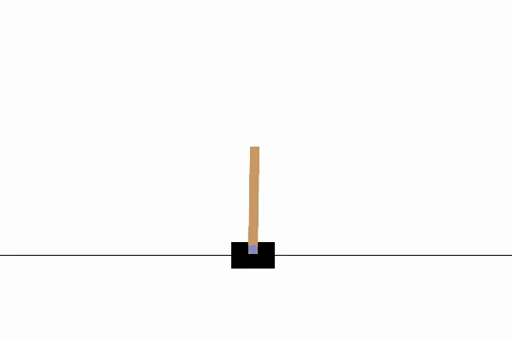
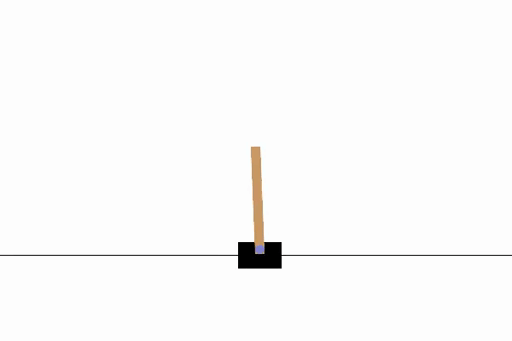

In [15]:
best_agent.demo_progression()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



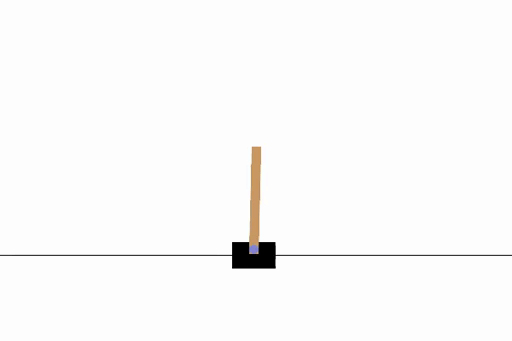
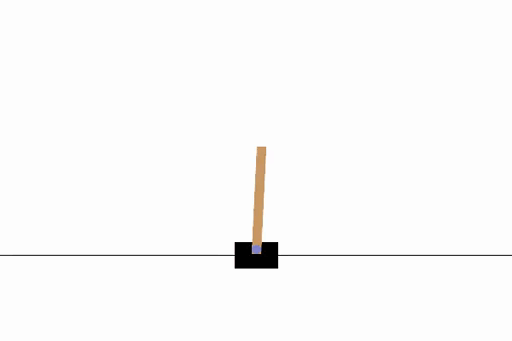

In [16]:
best_agent.demo_last()

In [17]:
reinforce_max_t, reinforce_max_r, reinforce_max_s, \
    reinforce_max_sec, reinforce_max_rt = np.max(reinforce_results, axis=0).T
reinforce_min_t, reinforce_min_r, reinforce_min_s, \
    reinforce_min_sec, reinforce_min_rt = np.min(reinforce_results, axis=0).T
reinforce_mean_t, reinforce_mean_r, reinforce_mean_s, \
    reinforce_mean_sec, reinforce_mean_rt = np.mean(reinforce_results, axis=0).T
reinforce_x = np.arange(len(reinforce_mean_s))

# reinforce_max_t, reinforce_max_r, reinforce_max_s, \
#     reinforce_max_sec, reinforce_max_rt = np.nanmax(reinforce_results, axis=0).T
# reinforce_min_t, reinforce_min_r, reinforce_min_s, \
#     reinforce_min_sec, reinforce_min_rt = np.nanmin(reinforce_results, axis=0).T
# reinforce_mean_t, reinforce_mean_r, reinforce_mean_s, \
#     reinforce_mean_sec, reinforce_mean_rt = np.nanmean(reinforce_results, axis=0).T
# reinforce_x = np.arange(len(reinforce_mean_s))

# change convergence checks to episode only (not minutes, not mean reward 'float('inf')' can help)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
reinforce_root_dir = os.path.join(RESULTS_DIR, 'reinforce')
not os.path.exists(reinforce_root_dir) and os.makedirs(reinforce_root_dir)

np.save(os.path.join(reinforce_root_dir, 'x'), reinforce_x)

np.save(os.path.join(reinforce_root_dir, 'max_r'), reinforce_max_r)
np.save(os.path.join(reinforce_root_dir, 'min_r'), reinforce_min_r)
np.save(os.path.join(reinforce_root_dir, 'mean_r'), reinforce_mean_r)

np.save(os.path.join(reinforce_root_dir, 'max_s'), reinforce_max_s)
np.save(os.path.join(reinforce_root_dir, 'min_s'), reinforce_min_s )
np.save(os.path.join(reinforce_root_dir, 'mean_s'), reinforce_mean_s)

np.save(os.path.join(reinforce_root_dir, 'max_t'), reinforce_max_t)
np.save(os.path.join(reinforce_root_dir, 'min_t'), reinforce_min_t)
np.save(os.path.join(reinforce_root_dir, 'mean_t'), reinforce_mean_t)

np.save(os.path.join(reinforce_root_dir, 'max_sec'), reinforce_max_sec)
np.save(os.path.join(reinforce_root_dir, 'min_sec'), reinforce_min_sec)
np.save(os.path.join(reinforce_root_dir, 'mean_sec'), reinforce_mean_sec)

np.save(os.path.join(reinforce_root_dir, 'max_rt'), reinforce_max_rt)
np.save(os.path.join(reinforce_root_dir, 'min_rt'), reinforce_min_rt)
np.save(os.path.join(reinforce_root_dir, 'mean_rt'), reinforce_mean_rt)

## Load from files

In [21]:
!rm -f results/reinforce/*
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_r.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_rt.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_s.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_sec.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_t.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_r.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_rt.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_s.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_sec.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_t.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/min_r.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/min_rt.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/min_s.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/min_sec.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/min_t.npy
!wget -nv -P results/reinforce https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/x.npy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2025-01-05 00:17:53 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_r.npy [80128/80128] -> "results/reinforce/max_r.npy" [1]
2025-01-05 00:17:53 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_rt.npy [80128/80128] -> "results/reinforce/max_rt.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_s.npy [80128/80128] -> "results/reinforce/max_s.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_sec.npy [80128/80128] -> "results/reinforce/max_sec.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/max_t.npy [80128/80128] -> "results/reinforce/max_t.npy" [1]
2025-01-05 00:17:54 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/reinforce/mean_r.npy [80128/80128] -> "results/reinforce/mean_r

In [22]:
reinforce_root_dir = os.path.join(RESULTS_DIR, 'reinforce')
reinforce_x = np.load(os.path.join(reinforce_root_dir, 'x.npy'))

reinforce_max_r = np.load(os.path.join(reinforce_root_dir, 'max_r.npy'))
reinforce_min_r = np.load(os.path.join(reinforce_root_dir, 'min_r.npy'))
reinforce_mean_r = np.load(os.path.join(reinforce_root_dir, 'mean_r.npy'))

reinforce_max_s = np.load(os.path.join(reinforce_root_dir, 'max_s.npy'))
reinforce_min_s = np.load(os.path.join(reinforce_root_dir, 'min_s.npy'))
reinforce_mean_s = np.load(os.path.join(reinforce_root_dir, 'mean_s.npy'))

reinforce_max_t = np.load(os.path.join(reinforce_root_dir, 'max_t.npy'))
reinforce_min_t = np.load(os.path.join(reinforce_root_dir, 'min_t.npy'))
reinforce_mean_t = np.load(os.path.join(reinforce_root_dir, 'mean_t.npy'))

reinforce_max_sec = np.load(os.path.join(reinforce_root_dir, 'max_sec.npy'))
reinforce_min_sec = np.load(os.path.join(reinforce_root_dir, 'min_sec.npy'))
reinforce_mean_sec = np.load(os.path.join(reinforce_root_dir, 'mean_sec.npy'))

reinforce_max_rt = np.load(os.path.join(reinforce_root_dir, 'max_rt.npy'))
reinforce_min_rt = np.load(os.path.join(reinforce_root_dir, 'min_rt.npy'))
reinforce_mean_rt = np.load(os.path.join(reinforce_root_dir, 'mean_rt.npy'))

## Plotting REINFORCE
The charts show high variance - i.e. wide bands.
In Monte-Carlo targets, the accumulation of random events along a trajectory, including the initial state sampled from
the initial state distribution, transition function probabilities, also here with stochastic policies, the randomness action selection adds to the mix. All this randomness is compounded inside the return, making it a high-variance signal challenging to interpret.

One way for reducing the variance is to use partial returns instead of the full return for changing the log-probabilities of actions. We already implemented this improvement. But another issue is that action log-probabilities change in the proportion of the return - i.e. return results in large change in Prob(action).

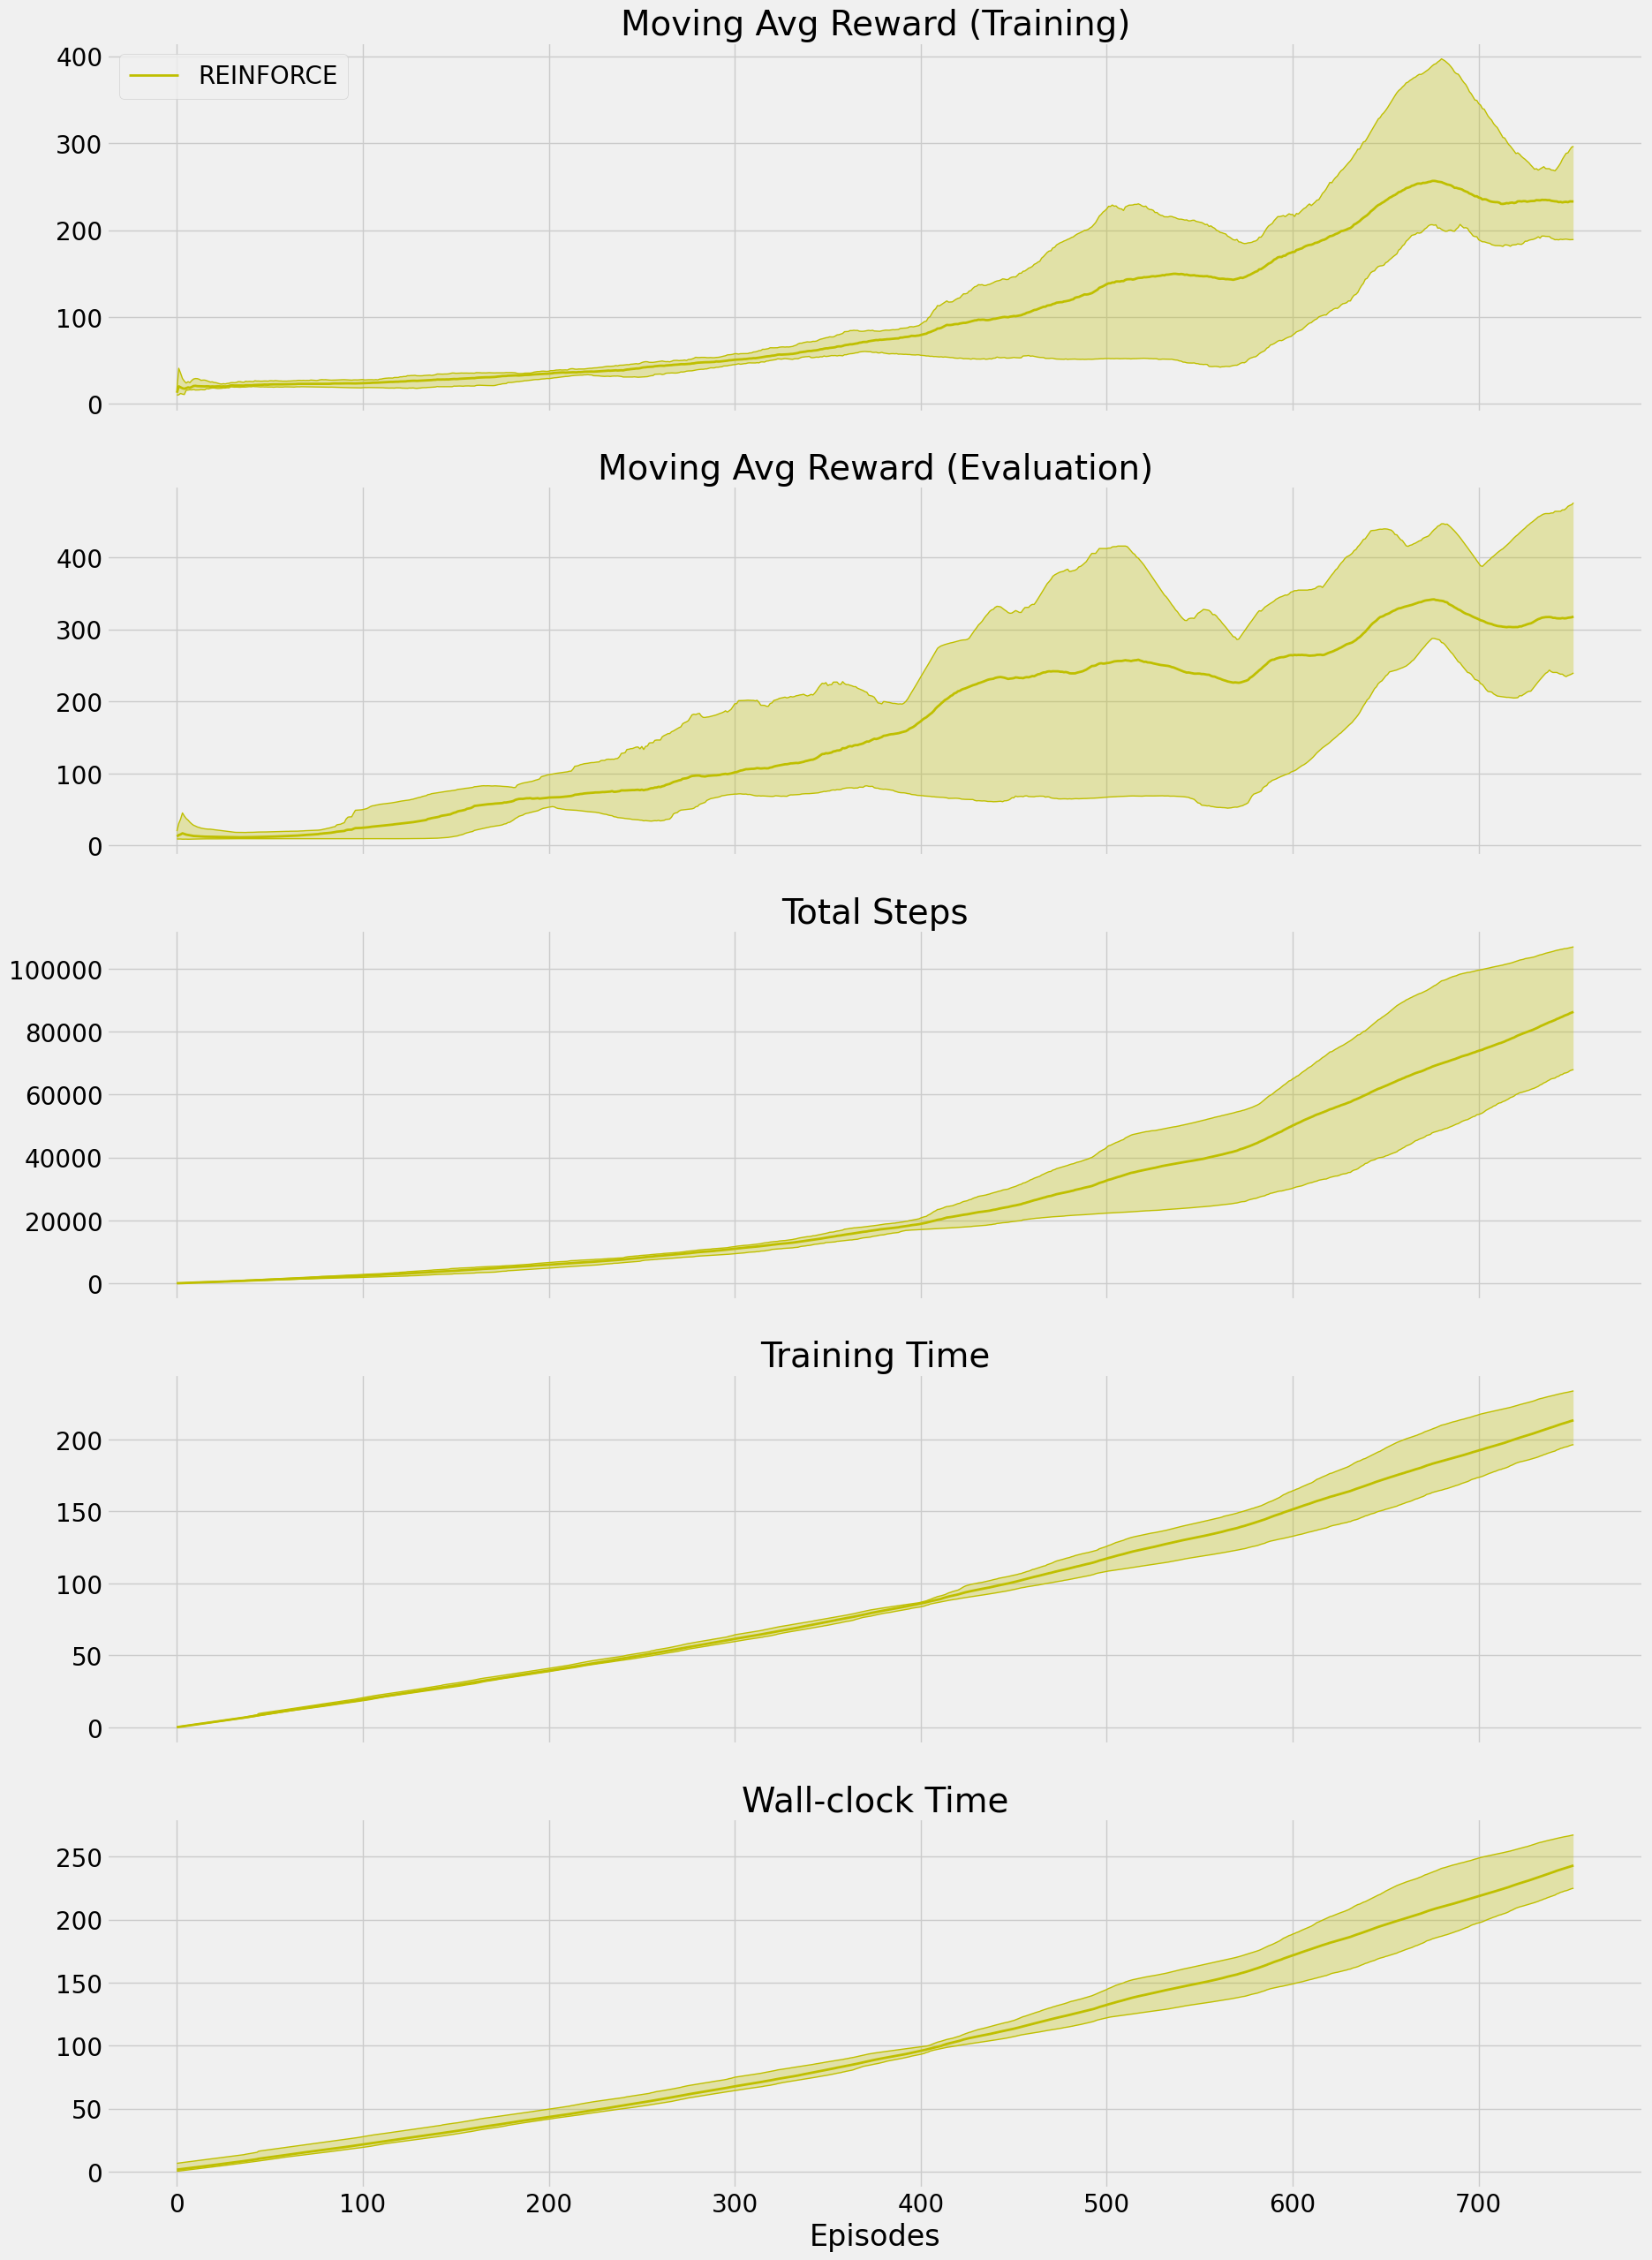

In [19]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# VPG
REINFORCE works well in simple problems and guarantee convergence. But because we use full Monte-Carlo returns for calculating gradient, its variance is a problem. **Vanilla Policy Gradient** (VPG) or **REINFORCE with baseline** address this problem.

In Cart Pole env, all rewards and returns are positive. In order to separate OK actions from the best, we need lots of data. The variance is very hard to muffle. So, instead of using noise returns, we can use Action Advantage to differentiate the value of actions in the same state.

Recall:

Definition of true action-adv function: $a_π(s,a)=q_π(s,a)-v_π(s)$

Approximation of the action-adv function: $A(S_t,A_t)\approx R_t+γR_{t+1}+\ldots +γ^{T-1}R_T - v_π(S_t)$

We can simplify it to get a not-too-bad estimation $A(S_t,A_t)=G_t-V(S_t)$

In [13]:
#value function neural network model

class FCV(nn.Module):
  def __init__(self, input_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super().__init__()
    self.activation_fc = activation_fc

    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.output_layer = nn.Linear(hidden_dims[-1], 1) # output_dim is 1 (value of the state)

    # device = "cpu"
    # if torch.cuda.is_available():
    #   device = "cuda:0"
    # self.device = torch.device(device)
    # self.to(self.device)

  def _format(self, state):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    x = self.output_layer(x)
    return x

## Entropy

A uniform distro (evenly distributed samples) has *high entropy*, in fact, the highest it can be.

In PyTorch, the natural log is used for calculating the entropy instead of the binary log. Mostly because the natural log uses Euler's number e, and makes math more 'natural'.
Practically speaking, however, there is no difference and the effects are the same. So, the entropy in the cart-pole environment, which has two actions, is between 0 and 0.6931.

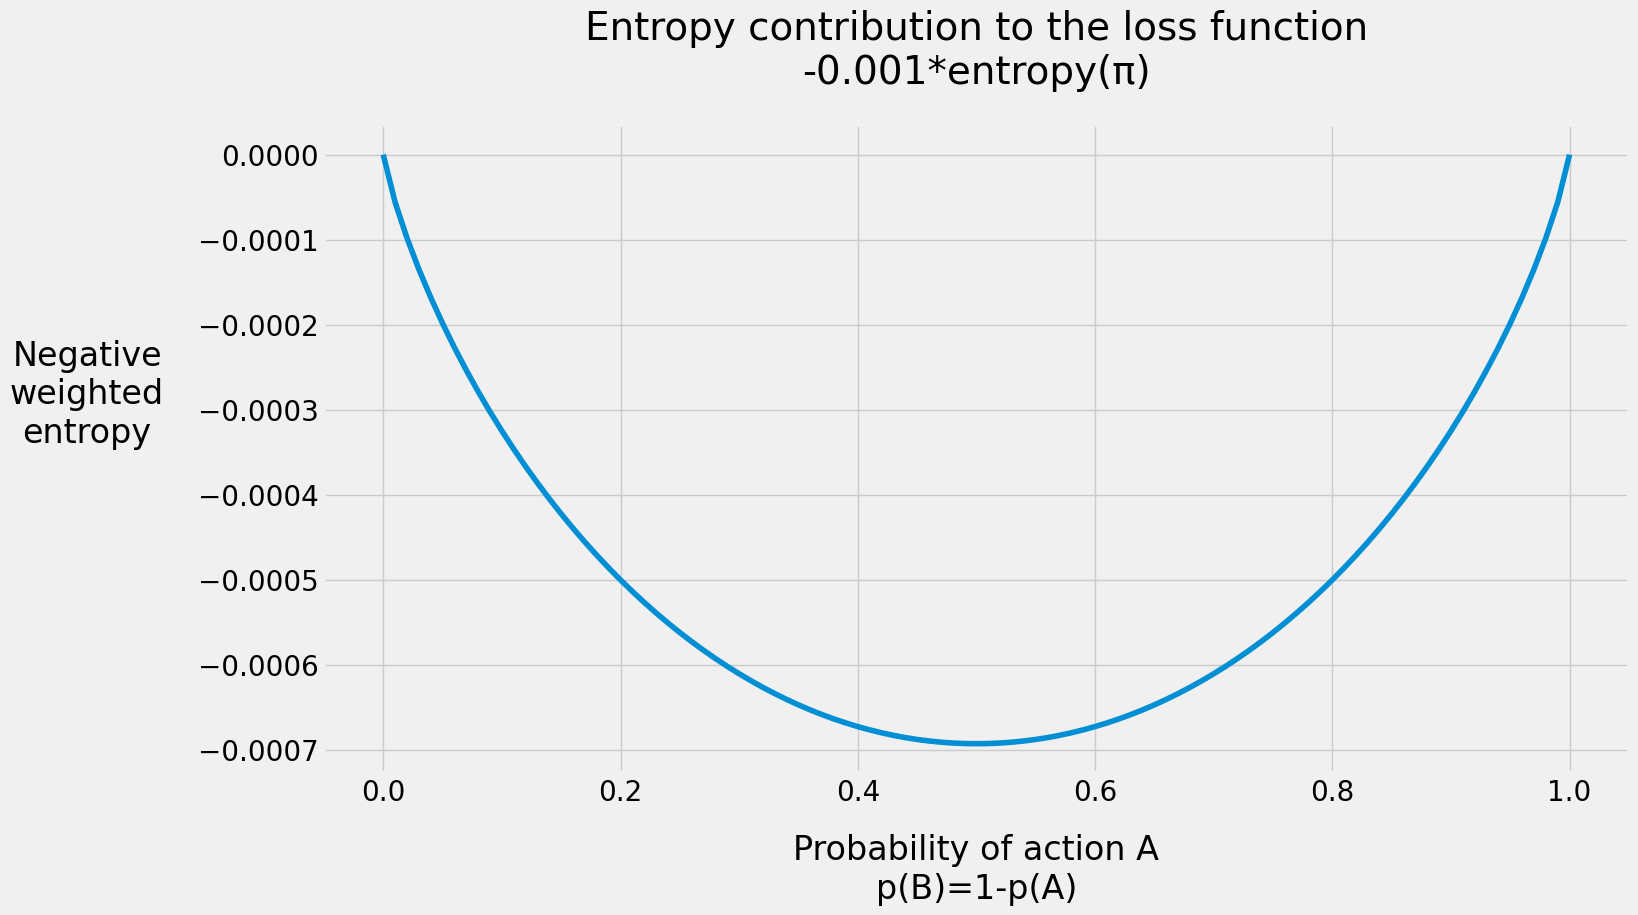

In [14]:
weight, probs, entropies = -0.001, [], []
for p in np.arange(0, 1.01, 0.01): # start, stop(exclusive), step
  probs.append(p)
  p = torch.FloatTensor([p, 1-p])
  d = torch.distributions.Categorical(probs=p)
  entropies.append(weight * d.entropy().item())
plt.plot(probs, entropies)
plt.xlabel('Probability of action A\np(B)=1-p(A)', labelpad=20)
plt.ylabel('Negative\nweighted\nentropy', labelpad=80, rotation=0)
plt.title('Entropy contribution to the loss function\n{}*entropy(π)'.format(weight), pad=30)
plt.show()

In [23]:
es = np.array(entropies) *1000.0 #/ weight
es.min(), es.mean(), es.std(), es.sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.6931471824645996,
 -0.4949242555268923,
 0.19300039268988073,
 -49.98734980821612)

## Loss Function for VPG

The way to use entropy in policy-gradient methods is to add the negative weighted entropy to the loss function to encourage having evenly distributed actions (highest entropy).

This is loss fn for value-fn: MSE MC error
$$L_v(ϕ) = \dfrac{1}{N}\sum_{n=0}^{N}\left[\left( G_t-V(S_t;ϕ)\right)^2\right]
$$

This is the loss fn for policy: negative because we want to minimise it.
$$L_π(θ) = -\dfrac{1}{N}\sum_{n=0}^{N}\left[\left(\underbrace{ G_t-V(S_t;ϕ)}_{\text{estimated} \\ \text{advantage}}\right)\underbrace{\log π(A_t|S_t;θ)}_{\text{log prob of} \\ \text{action taken}}+\underbrace{βH(\pi(S_t;θ))}_{\text{weighted entropy}}\right]
$$


In [48]:
class VPG():
  def __init__(self,
               policy_model_fn, # basically use FCDAP
               policy_model_max_grad_norm, # for clipping gradients of NN params
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn, # basically use FCV
               value_model_max_grad_norm, # for clipping gradients of NN params
               value_optimizer_fn,
               value_optimizer_lr,
               entropy_loss_weight):
    self.policy_model_fn = policy_model_fn
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.entropy_loss_weight = entropy_loss_weight

  def optimize_model(self):
    T = len(self.rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t]*self.rewards[t:]) for t in range(T)])

    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    # logpas, entropies, values are lists of tensors, populated by interaction_step()
    self.logpas = torch.cat(self.logpas) # concatenate elements of the list into one list
    self.entropies = torch.cat(self.entropies)
    self.values = torch.cat(self.values)

    # calc the value_error to use it to score the log-probs or the actions.
    value_error = returns - self.values # adv fn: G_t-V(S_t; phi)
    # we want to maximise the performance measure J, so put '-' in front
    policy_loss = -(discounts * value_error.detach() * self.logpas).mean()
    entropy_loss = -self.entropies.mean()
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # back prop
    self.policy_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(),
                                   self.policy_model_max_grad_norm)
    self.policy_optimizer.step()

    ## optimise the value-fn NN
    value_loss = value_error.pow(2).mul(0.5).mean()
    # back prop
    self.value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(self.value_model.parameters(),
                                   self.value_model_max_grad_norm)
    self.value_optimizer.step()

  def interaction_step(self, state, env):
    action, is_exploratory, logpa, entropy = self.policy_model.full_pass(state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

    self.logpas.append(logpa)
    self.entropies.append(entropy)
    self.rewards.append(reward)
    self.values.append(self.value_model(state))

    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(is_exploratory)
    return new_state, is_terminal, is_truncated

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.policy_model = self.policy_model_fn(nS, nA)
    self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                   self.policy_optimizer_lr)

    self.value_model = self.value_model_fn(nS)
    self.value_optimizer = self.value_optimizer_fn(self.value_model,
                                                   self.value_optimizer_lr)

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      # collect rollout
      self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
      for step in count(): # starting from 0
        state, is_terminal, is_truncated = self.interaction_step(state, env)
        if is_terminal:
          gc.collect()
          break

      is_failure = is_terminal and not is_truncated
      next_value = 0 if is_failure else self.value_model(state).detach().item()
      self.rewards.append(next_value)
      self.optimize_model()

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.policy_model, env)
      self.save_checkpoint(episode-1, self.policy_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        # a = self.evaluation_strategy.select_action(eval_policy_model, s)
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


## Train VPG

In [49]:
vpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  policy_optimizer_lr = 5e-4

  value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 7e-4

  entropy_loss_weight = 1e-3

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = VPG(policy_model_fn,
              policy_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              value_model_fn,
              value_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              entropy_loss_weight)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  vpg_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

vpg_results = np.array(vpg_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:01:00, ep 0156, ts 017428, ar 10 188.2±104.3, 100 152.8±093.6, ex 100 0.3±0.0, ev 365.5±128.4
el 00:02:00, ep 0248, ts 043358, ar 10 382.7±094.8, 100 274.7±127.0, ex 100 0.3±0.0, ev 423.6±102.4
el 00:03:01, ep 0319, ts 071595, ar 10 480.2±044.8, 100 381.7±115.3, ex 100 0.3±0.0, ev 455.2±079.7
el 00:03:48, ep 0368, ts 095020, ar 10 495.1±014.7, 100 443.7±090.4, ex 100 0.2±0.0, ev 475.3±062.3
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 492.99±27.07 in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.

el 00:00:00, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 010.0±000.0
el 00:01:00, ep 0167, ts 016023, ar 10 207.0±080.0, 100 132.8±078.1, ex 100 0.3±0.0, ev 342.5±137.8
el 00:02:00, ep 0246, ts 035978, ar 10 417.5±119.0, 100 242.1±112.9, ex 100 0.3±0.0, ev 414.0±112.5
el 00:03:00, ep 0307, ts 057838, ar 10

error: render=True



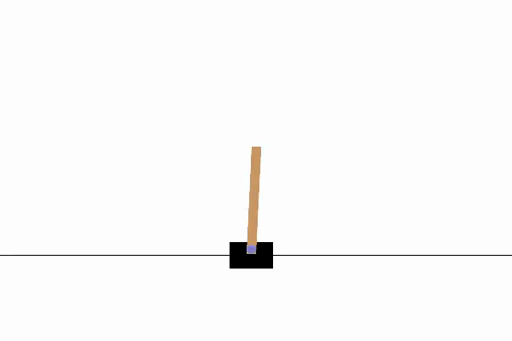
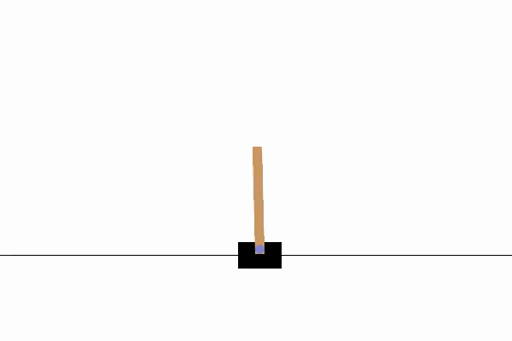

In [50]:
best_agent.demo_progression()

error: render=True



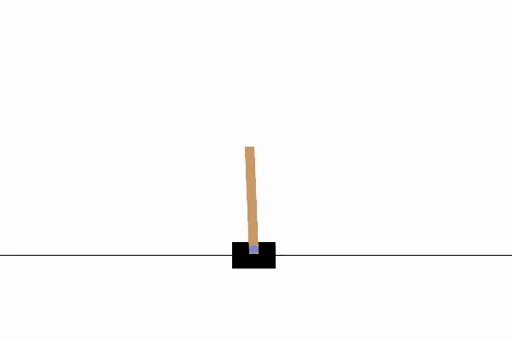
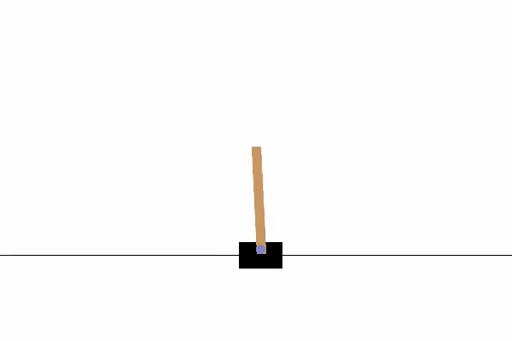

In [51]:
best_agent.demo_last()

In [55]:
vpg_max_t, vpg_max_r, vpg_max_s, vpg_max_sec, vpg_max_rt = np.max(vpg_results, axis=0).T
vpg_min_t, vpg_min_r, vpg_min_s, vpg_min_sec, vpg_min_rt = np.min(vpg_results, axis=0).T
vpg_mean_t, vpg_mean_r, vpg_mean_s, vpg_mean_sec, vpg_mean_rt = np.mean(vpg_results, axis=0).T
vpg_x = np.arange(np.max((len(vpg_mean_s), len(reinforce_mean_s))))

In [56]:
vpg_root_dir = os.path.join(RESULTS_DIR, 'vpg')
not os.path.exists(vpg_root_dir) and os.makedirs(vpg_root_dir)

np.save(os.path.join(vpg_root_dir, 'x'), vpg_x)

np.save(os.path.join(vpg_root_dir, 'max_r'), vpg_max_r)
np.save(os.path.join(vpg_root_dir, 'min_r'), vpg_min_r)
np.save(os.path.join(vpg_root_dir, 'mean_r'), vpg_mean_r)

np.save(os.path.join(vpg_root_dir, 'max_s'), vpg_max_s)
np.save(os.path.join(vpg_root_dir, 'min_s'), vpg_min_s )
np.save(os.path.join(vpg_root_dir, 'mean_s'), vpg_mean_s)

np.save(os.path.join(vpg_root_dir, 'max_t'), vpg_max_t)
np.save(os.path.join(vpg_root_dir, 'min_t'), vpg_min_t)
np.save(os.path.join(vpg_root_dir, 'mean_t'), vpg_mean_t)

np.save(os.path.join(vpg_root_dir, 'max_sec'), vpg_max_sec)
np.save(os.path.join(vpg_root_dir, 'min_sec'), vpg_min_sec)
np.save(os.path.join(vpg_root_dir, 'mean_sec'), vpg_mean_sec)

np.save(os.path.join(vpg_root_dir, 'max_rt'), vpg_max_rt)
np.save(os.path.join(vpg_root_dir, 'min_rt'), vpg_min_rt)
np.save(os.path.join(vpg_root_dir, 'mean_rt'), vpg_mean_rt)

## Load from files

In [23]:
!rm -f results/vpg/*
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_r.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_rt.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_s.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_sec.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_t.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_r.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_rt.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_s.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_sec.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_t.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_r.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_rt.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_s.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_sec.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/min_t.npy
!wget -nv -P results/vpg https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/x.npy

2025-01-05 00:17:57 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_r.npy [80128/80128] -> "results/vpg/max_r.npy" [1]
2025-01-05 00:17:58 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_rt.npy [80128/80128] -> "results/vpg/max_rt.npy" [1]
2025-01-05 00:17:58 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_s.npy [80128/80128] -> "results/vpg/max_s.npy" [1]
2025-01-05 00:17:58 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_sec.npy [80128/80128] -> "results/vpg/max_sec.npy" [1]
2025-01-05 00:17:59 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/max_t.npy [80128/80128] -> "results/vpg/max_t.npy" [1]
2025-01-05 00:17:59 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/vpg/mean_r.npy [80128/80128] -> "results/vpg/mean_r.npy" [1]
2025-01-05 00:17:59 URL:https://raw.githubusercontent.com/rome

In [24]:
vpg_root_dir = os.path.join(RESULTS_DIR, 'vpg')

vpg_x = np.load(os.path.join(vpg_root_dir, 'x.npy'))

vpg_max_r = np.load(os.path.join(vpg_root_dir, 'max_r.npy'))
vpg_min_r = np.load(os.path.join(vpg_root_dir, 'min_r.npy'))
vpg_mean_r = np.load(os.path.join(vpg_root_dir, 'mean_r.npy'))

vpg_max_s = np.load(os.path.join(vpg_root_dir, 'max_s.npy'))
vpg_min_s = np.load(os.path.join(vpg_root_dir, 'min_s.npy'))
vpg_mean_s = np.load(os.path.join(vpg_root_dir, 'mean_s.npy'))

vpg_max_t = np.load(os.path.join(vpg_root_dir, 'max_t.npy'))
vpg_min_t = np.load(os.path.join(vpg_root_dir, 'min_t.npy'))
vpg_mean_t = np.load(os.path.join(vpg_root_dir, 'mean_t.npy'))

vpg_max_sec = np.load(os.path.join(vpg_root_dir, 'max_sec.npy'))
vpg_min_sec = np.load(os.path.join(vpg_root_dir, 'min_sec.npy'))
vpg_mean_sec = np.load(os.path.join(vpg_root_dir, 'mean_sec.npy'))

vpg_max_rt = np.load(os.path.join(vpg_root_dir, 'max_rt.npy'))
vpg_min_rt = np.load(os.path.join(vpg_root_dir, 'min_rt.npy'))
vpg_mean_rt = np.load(os.path.join(vpg_root_dir, 'mean_rt.npy'))


## Plotting VPG

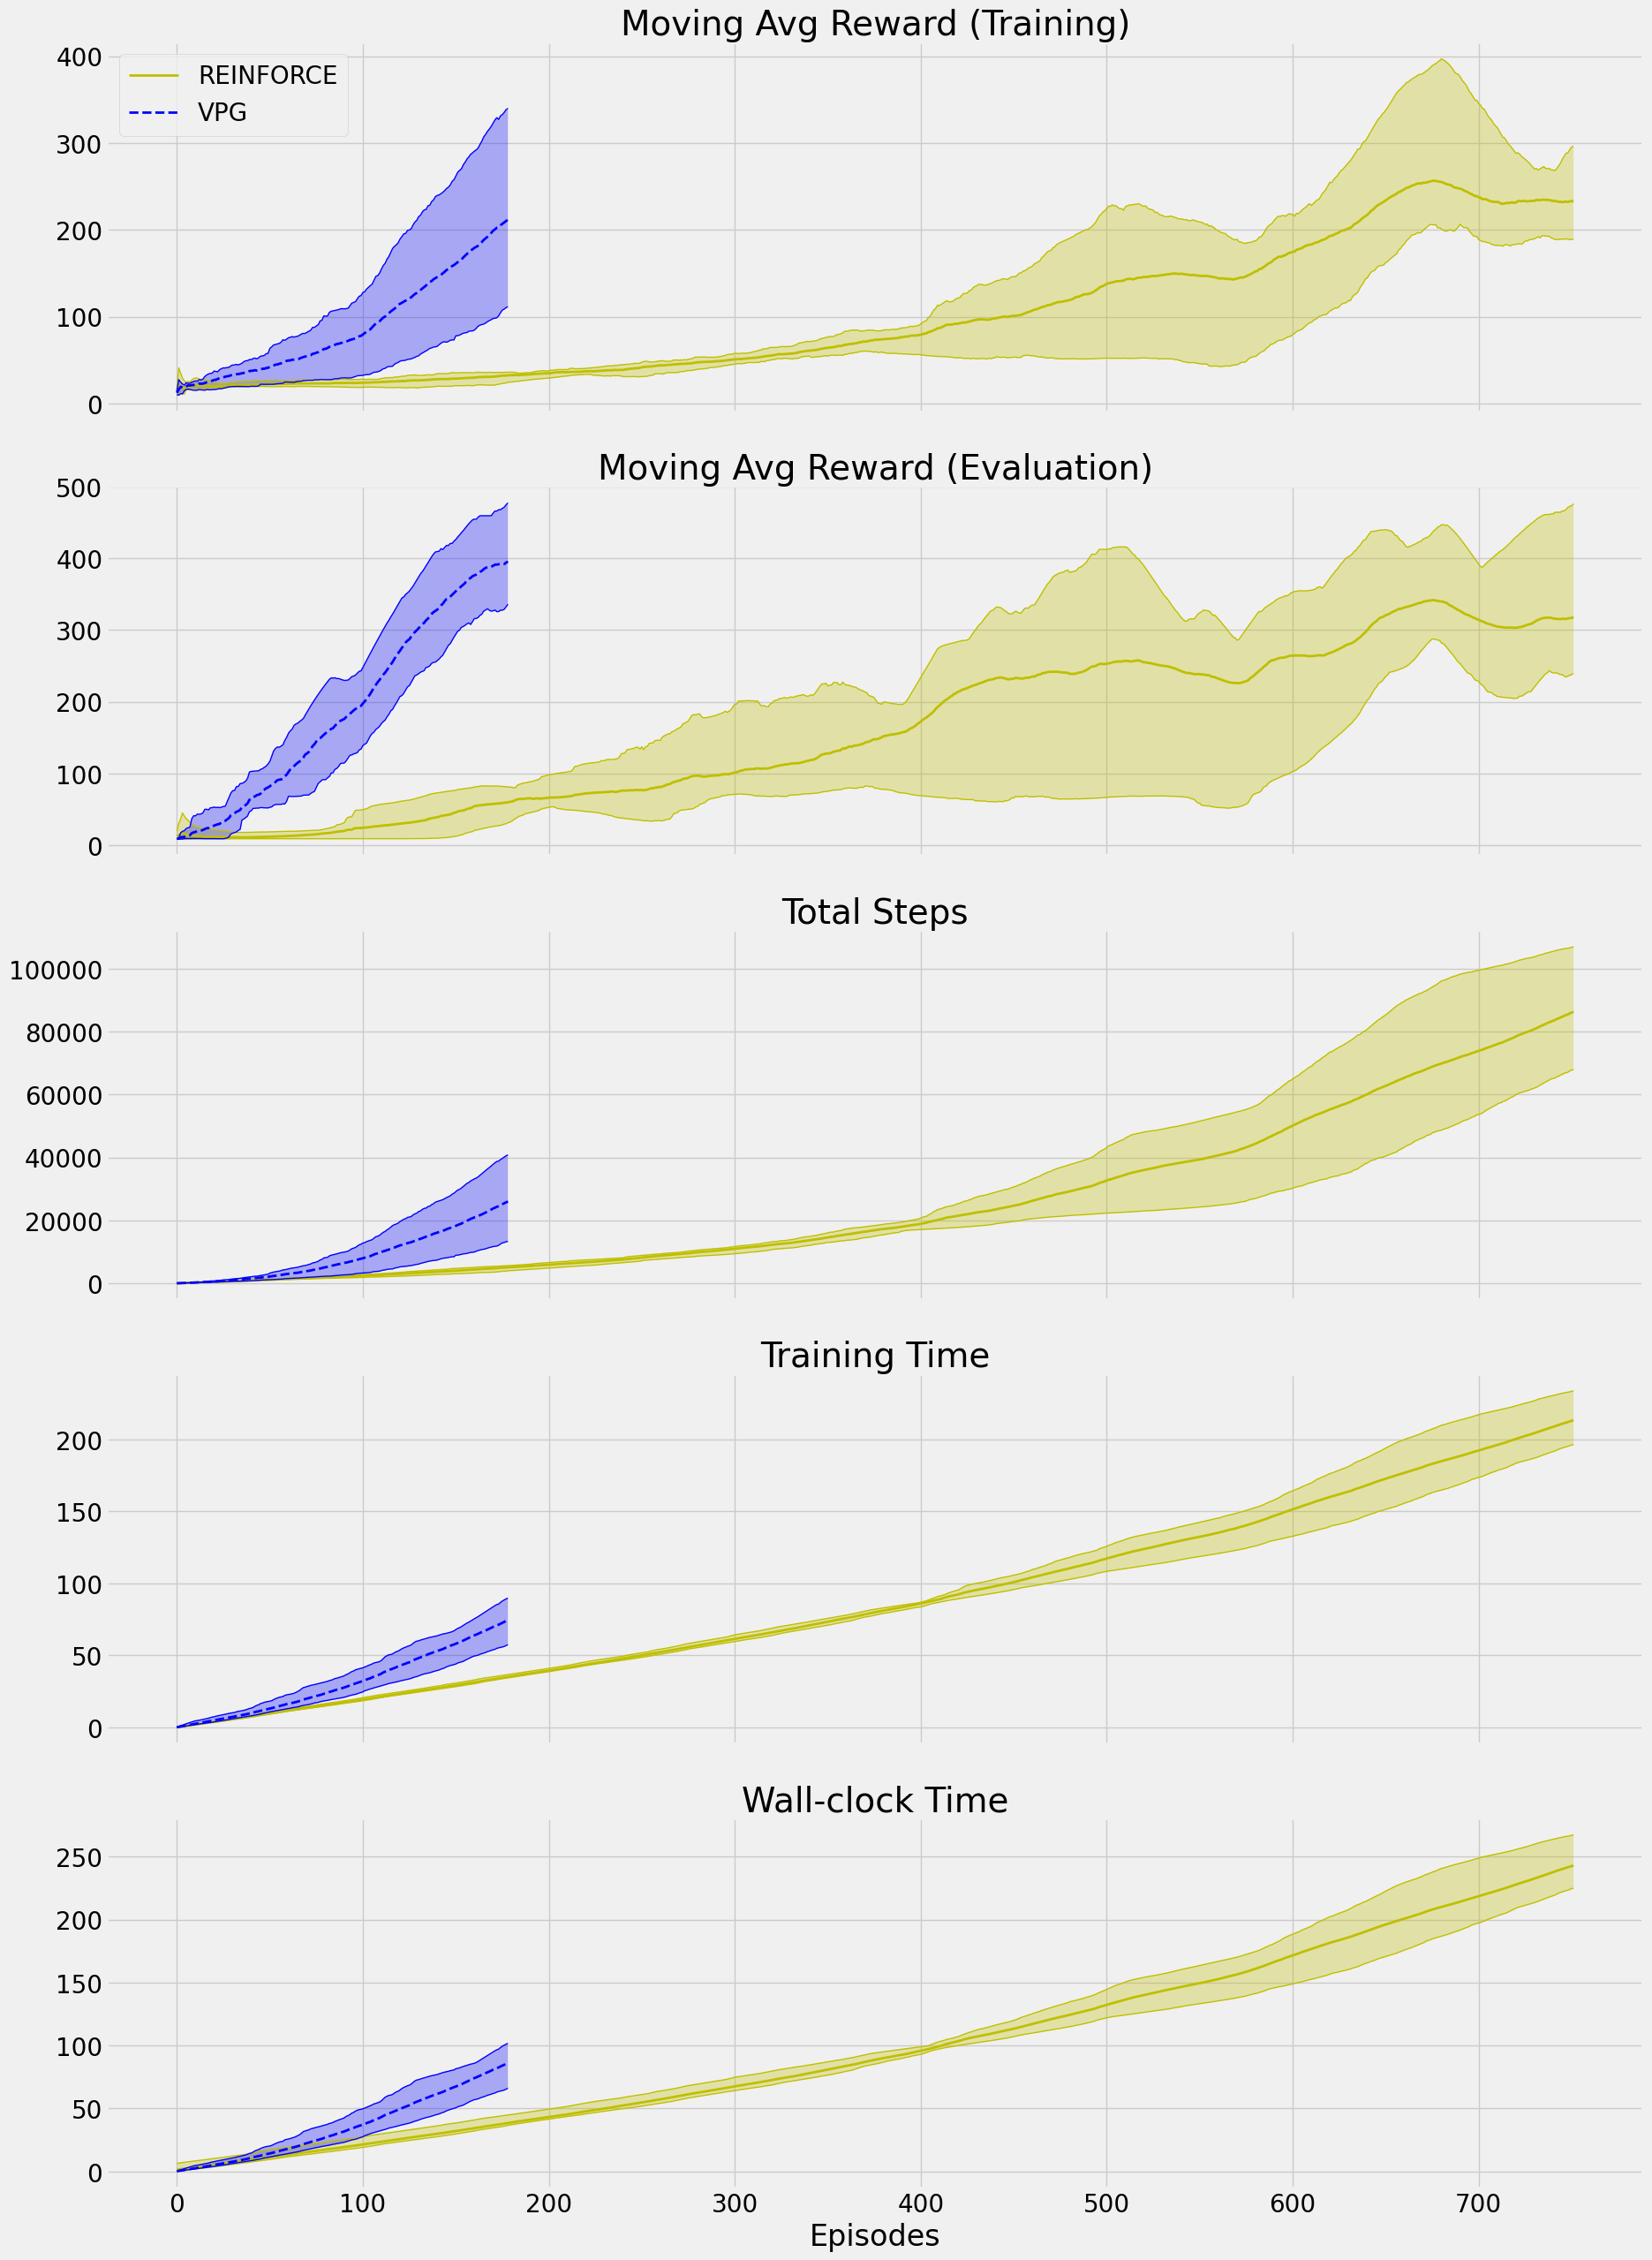

In [57]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# A3C
VPG is robust for simple problems. It uses MC returns without any bootstrapping. The only bias is because we use function approximation, which is inherently biased, but since the ANN is only a baseline used to reduce the variance of the actual return, there is very little bias introduced, if at all.

Often, to reduce variation, we add bias. An algo called **Acynchronous Advantage Actor-Critic** (A3C) further reduces bias:
1. it uses n-step returns with bootstrapping, to learn policy and value fn
2. it uses concurrent actors to generate a broad set of experience samples in parallel.

In A3C, we create multiple worker-learner, each having its own env, policy and V-fn neural netork weights, used for generating experiences.

After an experience batch is colllected, each worker updates the global policy and v-function model asynchronously, without coordination with other workers. Then they reload their copy of the models and keep at it.

In [14]:
# these impl of optims have shared memory for te parameters.

class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        super(SharedAdam, self).__init__(
            params, lr=lr, betas=betas, eps=eps,
            weight_decay=weight_decay, amsgrad=amsgrad)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['exp_avg'] = torch.zeros_like(p.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if amsgrad:
                    state['max_exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                # self.state[p]['steps'] = self.state[p]['shared_step'].item()
                # self.state[p]['shared_step'] += 1
                state = self.state[p]
                state['steps']  = state['shared_step'].item()
                state['shared_step'] += 1
        super().step(closure)

class SharedRMSprop(torch.optim.RMSprop):
    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0, centered=False):
        super(SharedRMSprop, self).__init__(
            params, lr=lr, alpha=alpha,
            eps=eps, weight_decay=weight_decay,
            momentum=momentum, centered=centered)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['square_avg'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if momentum > 0:
                    state['momentum_buffer'] = torch.zeros_like(p.data).share_memory_()
                if centered:
                    state['grad_avg'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['steps'] = self.state[p]['shared_step'].item()
                self.state[p]['shared_step'] += 1
        super().step(closure)


## n-Step Bootstrapping estimates

In VPG we used the full returns for our Advantage estimates: $A(S_t,A_t;ϕ) = G_t-V(S_t;ϕ)$

Now we use n-step returns with bootstrapping:
$$A(S_t,A_t;ϕ) = R_t+γR_{t+1}+\ldots+γ^nR_{t+n}+γ^{n+1}V(S_{t+n+1};ϕ)-V(S_t;\phi)
$$

Use tha above Adv in the following:
$$L_π(θ) = -\dfrac{1}{N}\sum_{n=0}^{N}\left[\underbrace{A(S_t,A_t;ϕ)}_{\text{estimated}\\ \text{advantage}}\underbrace{\log π(A_t|S_t;θ)}_{\text{log prob of} \\ \text{action taken}}+\underbrace{βH(\pi(S_t;θ))}_{\text{weighted entropy}}\right]
$$

Also use the n-step return to improve the value-function estimate.
$$L_v(ϕ) = \dfrac{1}{N}\sum_{n=0}^{N}\left[\left( R_t+γR_{t+1}+\ldots+γ^nR_{t+n}+γ^{n+1}V(S_{t+n+1};ϕ)-V(S_t;\phi)\right)^2\right]
$$

In [15]:
class A3C():
  def __init__(self,
               policy_model_fn, # basically use FCDAP
               policy_model_max_grad_norm, # for clipping gradients of NN params
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn, # basically use FCV
               value_model_max_grad_norm, # for clipping gradients of NN params
               value_optimizer_fn,
               value_optimizer_lr,
               entropy_loss_weight,
               max_n_steps,
               n_workers):
    self.policy_model_fn = policy_model_fn
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.entropy_loss_weight = entropy_loss_weight
    self.max_n_steps = max_n_steps
    self.n_workers = n_workers

  def optimize_model(self, logpas, entropies, rewards, values,
                     local_policy_model, local_value_model):
    # similar to VPG, but using input params instead of self.*
    T = len(rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t]*rewards[t:]) for t in range(T)])
    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    # logpas, entropies, values are lists of tensors, populated by interaction_step()
    logpas = torch.cat(logpas) # concatenate elements of the list into one list
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # calc the value_error to use it to score the log-probs or the actions.
    value_error = returns - values # adv fn: G_t-V(S_t; phi)
    # we want to maximise the performance measure J, so put '-' in front
    policy_loss = -(discounts * value_error.detach() * logpas).mean()
    entropy_loss = -entropies.mean()
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # back prop local model, update shared model, copy back to local model
    self.shared_policy_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(),
                                   self.policy_model_max_grad_norm)
    # iterating over all local and shared policy network parameters
    for param, shared_param in zip(local_policy_model.parameters(),
                                   self.shared_policy_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad # copy every gradient from the local to the shared model.
    self.shared_policy_optimizer.step()
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

    ## optimise the value-fn NN
    value_loss = value_error.pow(2).mul(0.5).mean()
    # back prop
    self.shared_value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(local_value_model.parameters(),
                                   self.value_model_max_grad_norm)
    for param, shared_param in zip(local_value_model.parameters(),
                                   self.shared_value_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad
    self.shared_value_optimizer.step()
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

  # static for concurrent workers can all
  @staticmethod
  def interaction_step(state, env, local_policy_model, local_value_model,
                       logpas, entropies, rewards, values):
    action, is_exploratory, logpa, entropy = local_policy_model.full_pass(state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

    logpas.append(logpa)
    entropies.append(entropy)
    rewards.append(reward)
    values.append(local_value_model(state))

    return new_state, reward, is_terminal, is_truncated, is_exploratory

  def work(self, rank):
    """
    work function that each worker loops around in.
    rand - is used as an ID for workers.
    """
    last_debug_time = float('-inf')
    self.stats['n_active_workers'].add_(1)

    # create unique seed per working to diversify experiences
    local_seed = self.seed + rank
    env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
    torch.manual_seed(local_seed) ; np.random.seed(local_seed) ; random.seed(local_seed)

    nS = env.observation_space.shape[0]
    nA = env.action_space.n

    # create local policy model and init its weights with shared model
    local_policy_model = self.policy_model_fn(nS, nA)
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
    # do the same with value model
    local_value_model = self.value_model_fn(nS)
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

    global_episode_idx = self.stats['episode'].add_(1).item() - 1
    # start training loop
    while not self.get_out_signal:
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      # we use n-step returns for training the policy and value functions
      n_steps_start = 0
      total_episode_rewards = 0
      total_episode_steps = 0
      total_episode_exploration = 0
      # collect rollout
      logpas, entropies, rewards, values = [], [], [], []

      for step in count(start=1): # starting from 1
        # collect a step of experience
        state, reward, is_terminal, is_truncated, is_exploratory = self.interaction_step(
            state, env, local_policy_model, local_value_model,
            logpas, entropies, rewards, values)

        total_episode_steps += 1
        total_episode_rewards += reward
        total_episode_exploration += int(is_exploratory)

        if is_terminal or step - n_steps_start == self.max_n_steps:
          is_failure = is_terminal and not is_truncated
          # value of next state
          next_value = 0 if is_failure else local_value_model(state).detach().item()
          # by appending next_value to rewards, the optimisation code from VPG
          # remains largely the same.
          rewards.append(next_value)

          self.optimize_model(logpas, entropies, rewards, values,
                              local_policy_model, local_value_model)
          logpas, entropies, rewards, values = [], [], [], []
          n_steps_start = step

        if is_terminal:
          gc.collect()
          break

      # save global stats
      episode_elapsed = time.time() - episode_start
      evaluation_score, _ = self.evaluate(local_policy_model, env)
      #print(f"worker {rank} saving checkpoints...")
      self.save_checkpoint(global_episode_idx, local_policy_model)

      self.stats['episode_elapsed'][global_episode_idx].add_(episode_elapsed)
      self.stats['episode_timestep'][global_episode_idx].add_(total_episode_steps)
      self.stats['episode_reward'][global_episode_idx].add_(total_episode_rewards)
      self.stats['episode_exploration'][global_episode_idx].add_(total_episode_exploration/total_episode_steps)
      self.stats['evaluation_scores'][global_episode_idx].add_(evaluation_score)

      mean_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].mean().item()
      mean_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].mean().item()
      mean_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].mean().item()
      mean_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].mean().item()
      std_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].std().item()
      std_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].std().item()
      std_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].std().item()
      std_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].std().item()
      if std_10_reward != std_10_reward: std_10_reward = 0
      if std_100_reward != std_100_reward: std_100_reward = 0
      if std_100_eval_score != std_100_eval_score: std_100_eval_score = 0
      if std_100_exp_rat != std_100_exp_rat: std_100_exp_rat = 0
      global_n_steps = self.stats['episode_timestep'][:global_episode_idx+1].sum().item()
      global_training_elapsed = self.stats['episode_elapsed'][:global_episode_idx+1].sum().item()
      wallclock_elapsed = time.time() - self.training_start

      self.stats['result'][global_episode_idx][0].add_(global_n_steps)
      self.stats['result'][global_episode_idx][1].add_(mean_100_reward)
      self.stats['result'][global_episode_idx][2].add_(mean_100_eval_score)
      self.stats['result'][global_episode_idx][3].add_(global_training_elapsed)
      self.stats['result'][global_episode_idx][4].add_(wallclock_elapsed)

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-self.training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, global_episode_idx, global_n_steps, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      if rank == 0:
        print(debug_message, end='\r', flush=True)
        if time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS:
          print(ERASE_LINE + debug_message, flush=True)
          last_debug_time = time.time()

      with self.get_out_lock:
        potential_next_global_episode_idx = self.stats['episode'].item()
        self.reached_goal_mean_reward.add_( mean_100_eval_score>=self.goal_mean_100_reward)
        self.reached_max_minutes.add_(time.time()-self.training_start >= self.max_minutes*60)
        self.reached_max_episodes.add_(potential_next_global_episode_idx >= self.max_episodes)
        if self.reached_max_episodes or \
          self.reached_max_minutes or \
          self.reached_goal_mean_reward:
          self.get_out_signal.add_(1)
          break
        # else go work on another episode
        global_episode_idx = self.stats['episode'].add_(1).item() - 1

    while rank == 0 and self.stats['n_active_workers'].item() > 1:
      pass

    if rank == 0:
      print(ERASE_LINE + debug_message)
      if self.reached_max_minutes: print(u'--> reached_max_minutes \u2715')
      if self.reached_max_episodes: print(u'--> reached_max_episodes \u2715')
      if self.reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')

    env.close(); del env
    self.stats['n_active_workers'].sub_(1)

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    nS, nA = env.observation_space.shape[0], env.action_space.n
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    self.stats = {}
    self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
    self.stats['result'] = torch.zeros([max_episodes, 5]).share_memory_()
    self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_reward'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_timestep'] = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
    self.stats['episode_exploration'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_elapsed'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

    self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
    self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model,
                                                            self.policy_optimizer_lr)
    self.shared_value_model = self.value_model_fn(nS).share_memory()
    self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model,
                                                          self.value_optimizer_lr)

    self.get_out_lock = mp.Lock() # capital L
    self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_goal_mean_reward = torch.zeros(1, dtype=torch.int).share_memory_()
    self.training_start = time.time()

    # spawn the workers
    workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
    [w.start() for w in workers]
    [w.join() for w in workers]
    wallclock_time = time.time() - self.training_start

    final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
    env.close(); del env

    final_episode = self.stats['episode'].item()
    training_time = self.stats['episode_elapsed'][:final_episode+1].sum().item()

    print('Training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
          ' {:.2f}s wall-clock time.\n'.format(
              final_eval_score, score_std, training_time, wallclock_time))

    self.stats['result'] = self.stats['result'].numpy()
    self.stats['result'][final_episode:, ...] = np.nan
    self.get_cleaned_checkpoints()
    return self.stats['result'], final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    #print(f'checkpoint_dir {self.checkpoint_dir}')
    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))

    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.shared_policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.shared_policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    #print(f"save_checkpoint {episode_idx} !!!!!!!!!!!!!!!!")
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


## Train A3C

In [54]:
a3c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 10,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
  policy_optimizer_lr = 0.0005

  value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 0.0007

  entropy_loss_weight = 0.001

  max_n_steps = 50
  n_workers = 8

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = A3C(policy_model_fn,
              policy_model_max_grad_norm,
              policy_optimizer_fn,
              policy_optimizer_lr,
              value_model_fn,
              value_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              entropy_loss_weight,
              max_n_steps,
              n_workers)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
  a3c_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent
a3c_results = np.array(a3c_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

el 00:00:01, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.5±0.0, ev 020.0±000.0
el 00:01:02, ep 0267, ts 010182, ar 10 084.8±044.6, 100 054.2±038.1, ex 100 0.4±0.1, ev 116.7±068.5
el 00:02:03, ep 0402, ts 031270, ar 10 197.2±092.5, 100 183.6±109.1, ex 100 0.3±0.0, ev 296.8±123.9
el 00:03:10, ep 0506, ts 055743, ar 10 323.7±169.7, 100 237.4±116.0, ex 100 0.3±0.0, ev 287.3±128.5
el 00:04:18, ep 0586, ts 085679, ar 10 430.6±156.9, 100 361.1±126.2, ex 100 0.2±0.0, ev 421.1±111.5
el 00:05:21, ep 0650, ts 113522, ar 10 500.0±000.0, 100 422.6±110.2, ex 100 0.2±0.0, ev 445.3±102.8
el 00:06:23, ep 0723, ts 143107, ar 10 500.0±000.0, 100 430.9±105.9, ex 100 0.2±0.0, ev 441.8±098.9
el 00:07:19, ep 0779, ts 169072, ar 10 466.3±060.6, 100 470.1±060.7, ex 100 0.2±0.0, ev 481.5±049.8
--> reach_goal_mean_reward ✓


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training complete.
Final evaluation score 500.00±0.00 in 3149.01s training time, 440.54s wall-clock time.

el 00:00:01, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 011.0±000.0
el 00:01:03, ep 0278, ts 008783, ar 10 069.8±020.9, 100 039.8±022.5, ex 100 0.4±0.1, ev 107.2±114.6
el 00:02:03, ep 0442, ts 023183, ar 10 176.1±069.3, 100 109.8±064.1, ex 100 0.4±0.0, ev 419.4±113.1
el 00:03:07, ep 0551, ts 047799, ar 10 204.5±047.3, 100 230.2±085.8, ex 100 0.3±0.0, ev 330.3±117.7
el 00:04:13, ep 0625, ts 070853, ar 10 445.4±082.4, 100 297.6±123.4, ex 100 0.3±0.0, ev 361.6±143.4
el 00:05:19, ep 0692, ts 101205, ar 10 474.1±081.9, 100 435.6±096.9, ex 100 0.3±0.0, ev 475.5±065.0
el 00:05:19, ep 0692, ts 101205, ar 10 474.1±081.9, 100 435.6±096.9, ex 100 0.3±0.0, ev 475.5±065.0
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 2284.04s training time, 326.45s wall-clock time.

el 00:00:02, ep 0000, ts 000013, ar 10 013.0±000.0, 100 0

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will


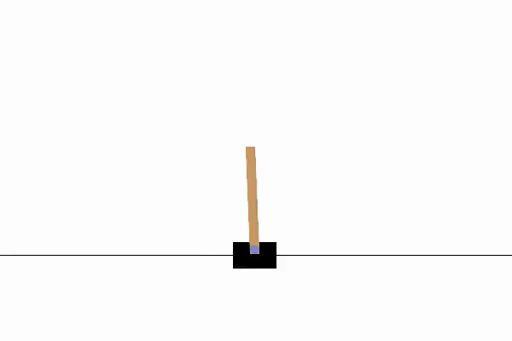
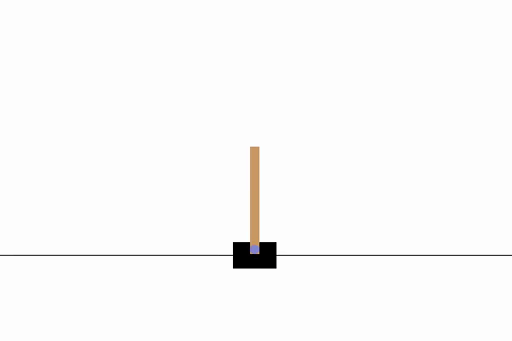

In [55]:
best_agent.demo_progression()

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecate


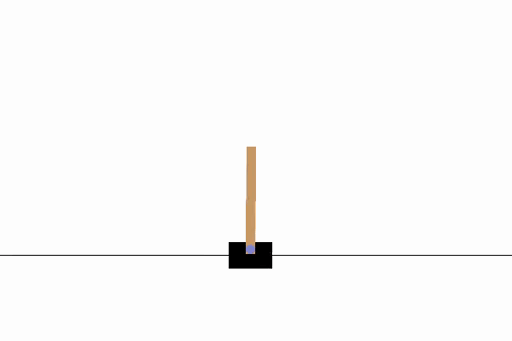
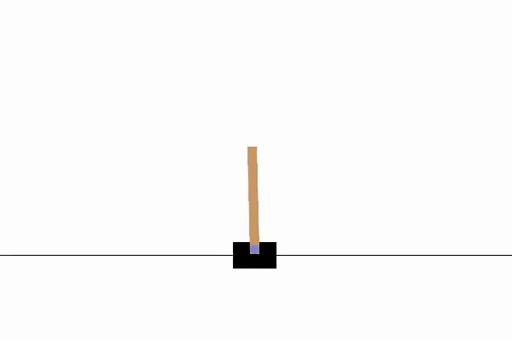

In [56]:
best_agent.demo_last()

In [57]:
a3c_max_t, a3c_max_r, a3c_max_s, a3c_max_sec, a3c_max_rt = np.max(a3c_results, axis=0).T
a3c_min_t, a3c_min_r, a3c_min_s, a3c_min_sec, a3c_min_rt = np.min(a3c_results, axis=0).T
a3c_mean_t, a3c_mean_r, a3c_mean_s, a3c_mean_sec, a3c_mean_rt = np.mean(a3c_results, axis=0).T
a3c_x = np.arange(np.max((len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [58]:
a3c_root_dir = os.path.join(RESULTS_DIR, 'a3c')
not os.path.exists(a3c_root_dir) and os.makedirs(a3c_root_dir)

np.save(os.path.join(a3c_root_dir, 'x'), a3c_x)

np.save(os.path.join(a3c_root_dir, 'max_r'), a3c_max_r)
np.save(os.path.join(a3c_root_dir, 'min_r'), a3c_min_r)
np.save(os.path.join(a3c_root_dir, 'mean_r'), a3c_mean_r)

np.save(os.path.join(a3c_root_dir, 'max_s'), a3c_max_s)
np.save(os.path.join(a3c_root_dir, 'min_s'), a3c_min_s )
np.save(os.path.join(a3c_root_dir, 'mean_s'), a3c_mean_s)

np.save(os.path.join(a3c_root_dir, 'max_t'), a3c_max_t)
np.save(os.path.join(a3c_root_dir, 'min_t'), a3c_min_t)
np.save(os.path.join(a3c_root_dir, 'mean_t'), a3c_mean_t)

np.save(os.path.join(a3c_root_dir, 'max_sec'), a3c_max_sec)
np.save(os.path.join(a3c_root_dir, 'min_sec'), a3c_min_sec)
np.save(os.path.join(a3c_root_dir, 'mean_sec'), a3c_mean_sec)

np.save(os.path.join(a3c_root_dir, 'max_rt'), a3c_max_rt)
np.save(os.path.join(a3c_root_dir, 'min_rt'), a3c_min_rt)
np.save(os.path.join(a3c_root_dir, 'mean_rt'), a3c_mean_rt)

## load from files

In [25]:
!rm -f results/a3c/*
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_r.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_rt.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_s.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_sec.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_t.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_r.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_rt.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_s.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_sec.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_t.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_r.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_rt.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_s.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_sec.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/min_t.npy
!wget -nv -P results/a3c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/x.npy

2025-01-05 00:18:02 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_r.npy [40128/40128] -> "results/a3c/max_r.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_rt.npy [40128/40128] -> "results/a3c/max_rt.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_s.npy [40128/40128] -> "results/a3c/max_s.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_sec.npy [40128/40128] -> "results/a3c/max_sec.npy" [1]
2025-01-05 00:18:03 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/max_t.npy [40128/40128] -> "results/a3c/max_t.npy" [1]
2025-01-05 00:18:04 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a3c/mean_r.npy [40128/40128] -> "results/a3c/mean_r.npy" [1]
2025-01-05 00:18:04 URL:https://raw.githubusercontent.com/rome

In [26]:
a3c_root_dir = os.path.join(RESULTS_DIR, 'a3c')

a3c_x = np.load(os.path.join(a3c_root_dir, 'x.npy'))

a3c_max_r = np.load(os.path.join(a3c_root_dir, 'max_r.npy'))
a3c_min_r = np.load(os.path.join(a3c_root_dir, 'min_r.npy'))
a3c_mean_r = np.load(os.path.join(a3c_root_dir, 'mean_r.npy'))

a3c_max_s = np.load(os.path.join(a3c_root_dir, 'max_s.npy'))
a3c_min_s = np.load(os.path.join(a3c_root_dir, 'min_s.npy'))
a3c_mean_s = np.load(os.path.join(a3c_root_dir, 'mean_s.npy'))

a3c_max_t = np.load(os.path.join(a3c_root_dir, 'max_t.npy'))
a3c_min_t = np.load(os.path.join(a3c_root_dir, 'min_t.npy'))
a3c_mean_t = np.load(os.path.join(a3c_root_dir, 'mean_t.npy'))

a3c_max_sec = np.load(os.path.join(a3c_root_dir, 'max_sec.npy'))
a3c_min_sec = np.load(os.path.join(a3c_root_dir, 'min_sec.npy'))
a3c_mean_sec = np.load(os.path.join(a3c_root_dir, 'mean_sec.npy'))

a3c_max_rt = np.load(os.path.join(a3c_root_dir, 'max_rt.npy'))
a3c_min_rt = np.load(os.path.join(a3c_root_dir, 'min_rt.npy'))
a3c_mean_rt = np.load(os.path.join(a3c_root_dir, 'mean_rt.npy'))

## plotting A3C

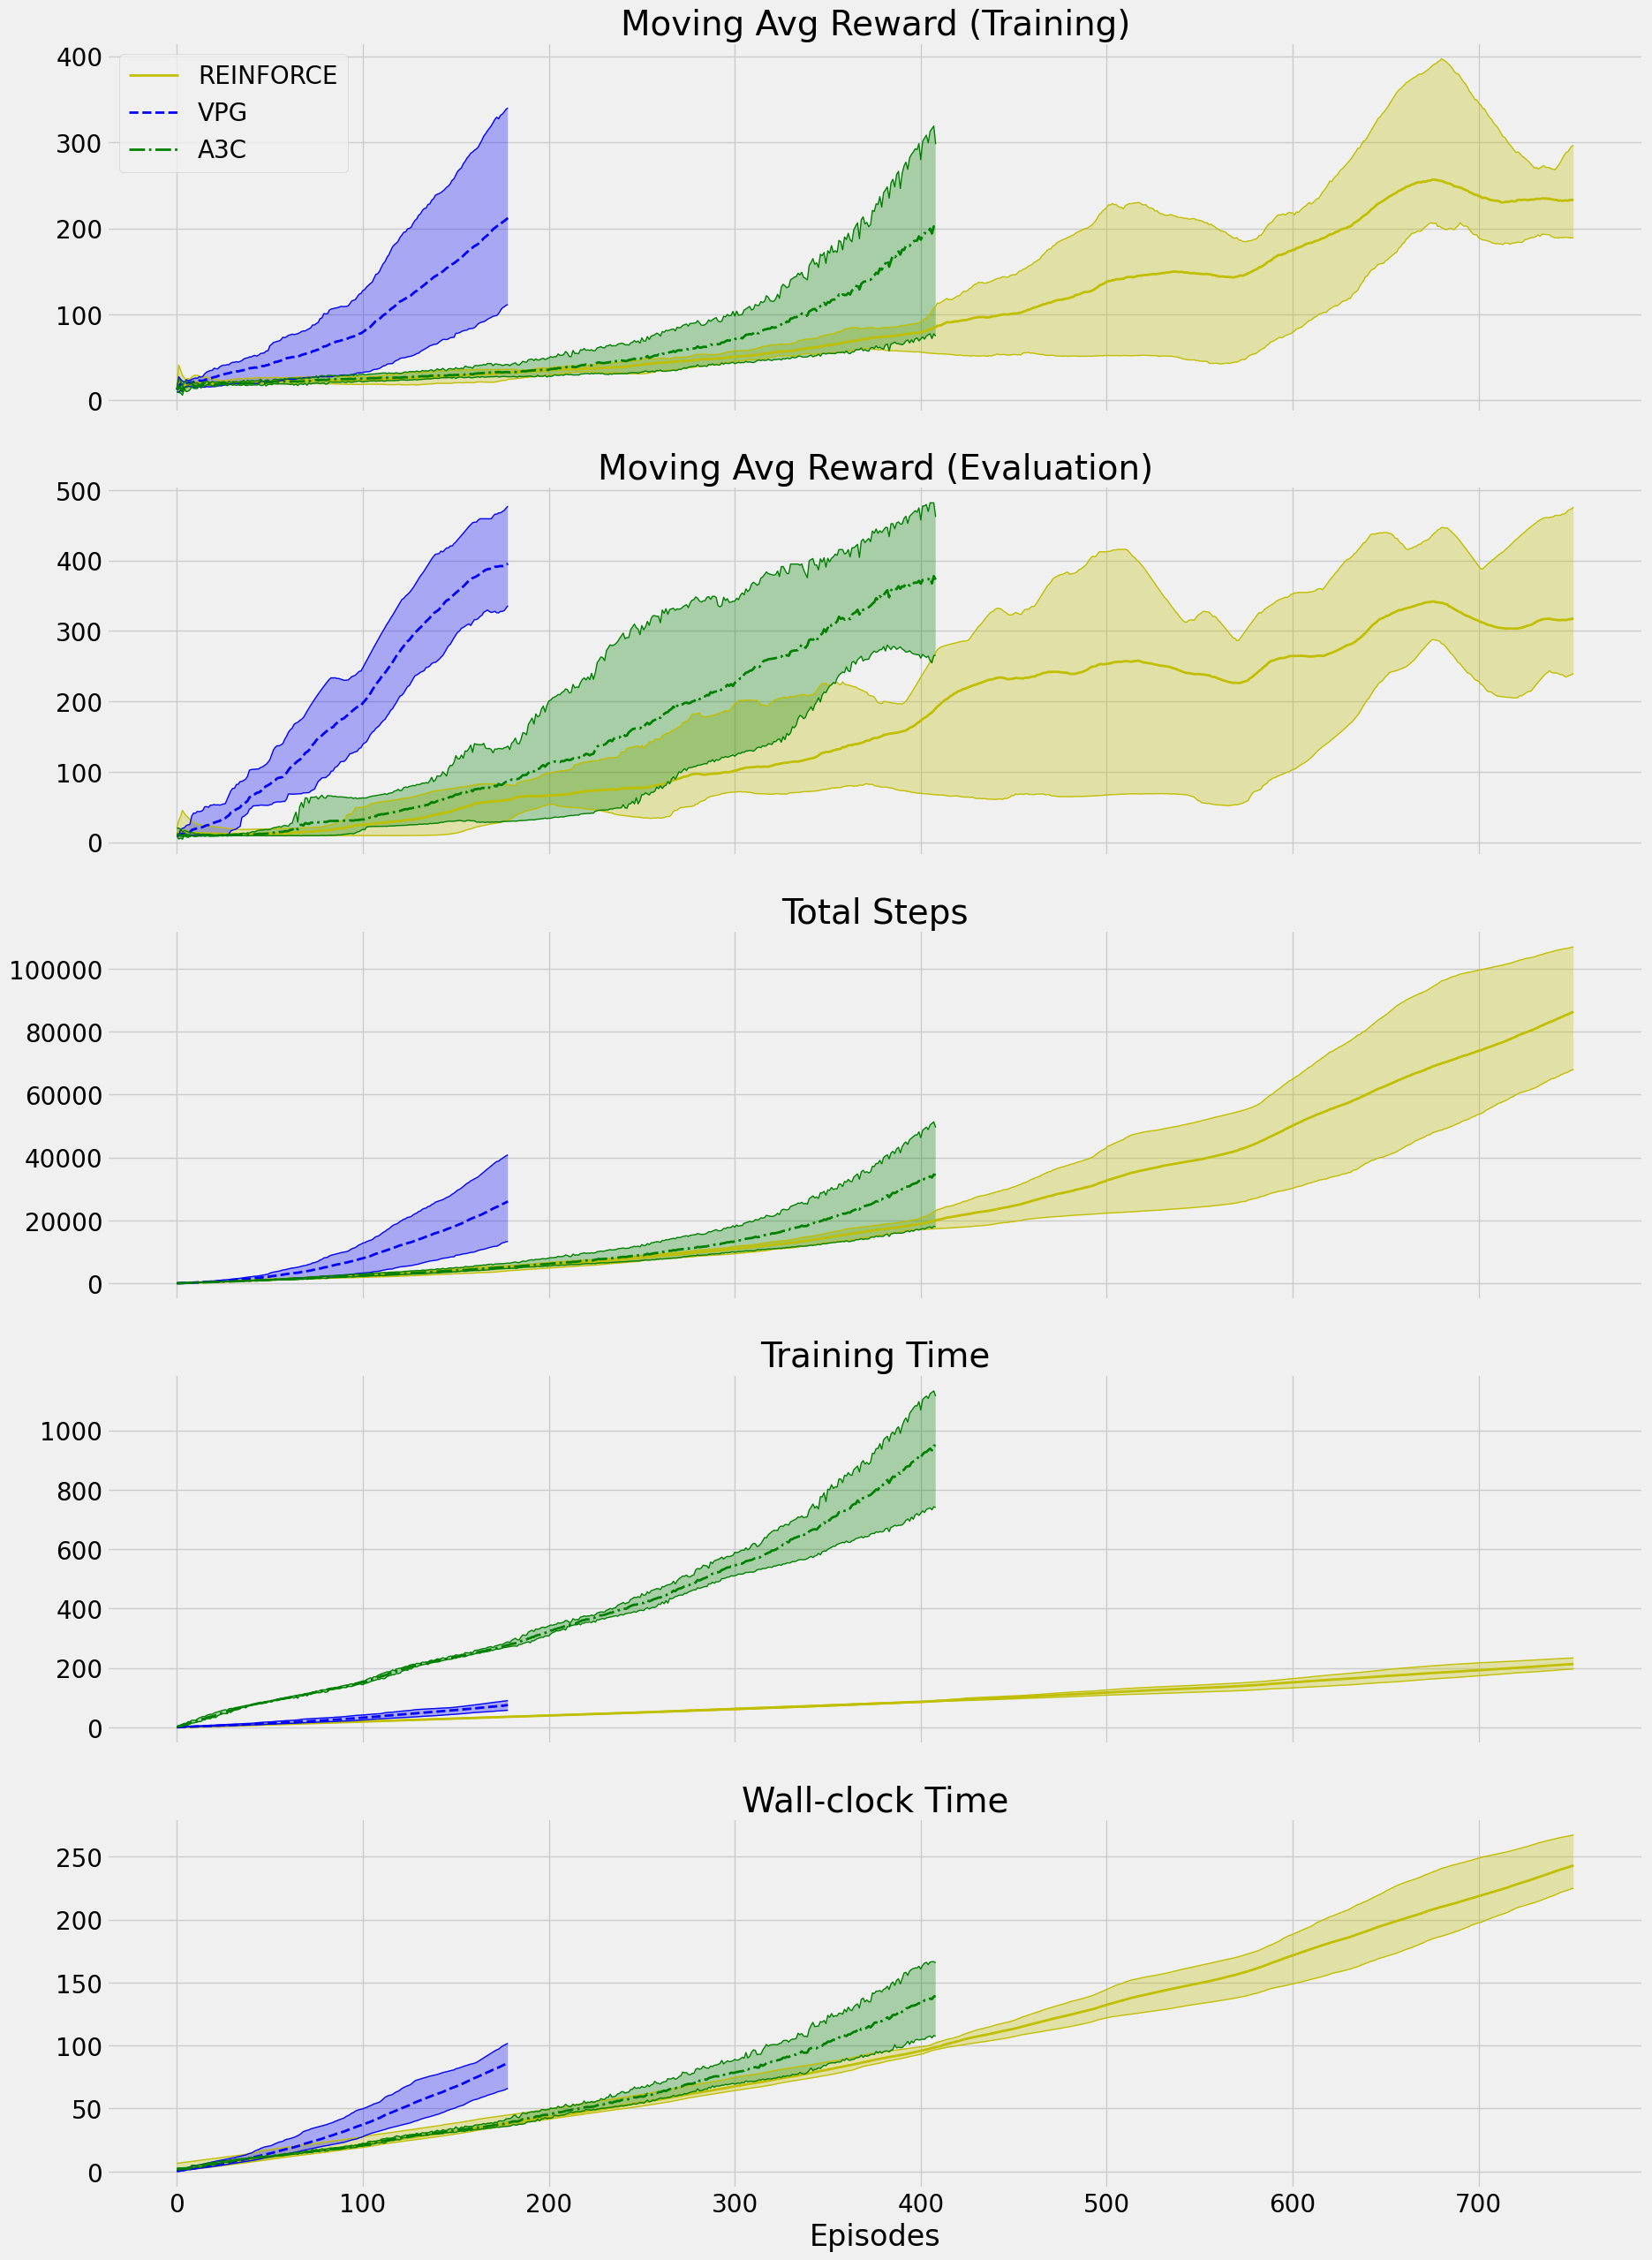

In [59]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# GAE

**Generalised Advantage Estimation** (GAE) combines multiple n-step bootstrapping targets in a single target, which is more robust. It's analagous to the λ-target in TD(λ), but for advantages.

In policy-gradient and actor-critic methods, we try to estimate the gradient of the following form:
$$g = \mathbb E\left[\sum_{t=0}^{∞}\psi_t\nabla_θ \log π(A_t|S_t;θ)\right]
$$

We can replace Ψ for a number of rexpressions that estimate the score with different levels of variance and bias:
* this is the total return starting from step 0, to the end: $\psi_t=\sum_{t=0}^{T}γ^tR_t$
* but as in REINFORCE, we can start at the current timestep and go to the end of the episode:  $\psi_t=\sum_{t'=t}^{T}γ^{t'-t}R_{t'}$
* as in VPG, we can use a baseline, which in our case was the state-value function: $\psi_t=\sum_{t'=t}^{T}γ^{t'-t}R_{t'}-b(S_t)$
* In A3C, we used the n-step adv estimate, which is the lowest variance (really?): $ψ_t=a_π(S_t,A_t)$
* but we could also use the true action-value function:  $ψ_t=q_π(S_t,A_t)$
* or even the TD residual, which can be seen as a one-step adv est.: $\psi_t = R_t+v_\pi(S_{t+1})-v_\pi(S_t)$

N-step advantage estimates:
* 1-step: $A^1(S_t,A_t;\phi)=R_t+\gamma V(S_{t+1};\phi)-V(S_t;\phi)$
* 2-step: $A^2(S_t,A_t;\phi)=R_t+\gamma R_{t+1}+\gamma^2 V(S_{t+2};\phi)-V(S_t;\phi)$
* 3-step: $A^3(S_t,A_t;\phi)=R_t+\gamma R_{t+1}+\gamma^2R_{t+2}+\gamma^3 V(S_{t+3};\phi)-V(S_t;\phi)$
* $\ldots$
* n-step: $A^n(S_t,A_t;\phi)=R_t+\gamma R_{t+1}+\gamma^2R_{t+2}+\gamma^n V(S_{t+n};\phi)-V(S_t;\phi)$

which we can mix to make an estimate analogous to TD-λ but for advantages:
$$A^{GAE(\gamma,\lambda)}(S_t,A_t;\phi)=\sum_{l=0}^{∞}(\gamma\lambda)^l\delta_{t+l}
$$
similarly, when λ=0, it returns the 1-step adv est: $A^{GAE(\gamma,0)}(S_t,A_t;\phi)=R_t+\gamma V(S_{t+1};\phi)-V(S_t;\phi)$

and when λ=1, it returns the infinite-step adv est: $A^{GAE(\gamma,1)}(S_t,A_t;\phi)=\sum_{l=0}^{\infty}\gamma^lR_{t+l}-V(S_t;\phi)$

We can use several different targets to train the state-value function neural network used to calculate GAE values:
* we could use the reward to go, aka Monte-Carlo returns: $y_t=\sum_{t'=t}^{T}\gamma^{t'-t}R_{t'}$
* the n-step bootstrapping target, incl the TD target: $y_t=R_t+\gamma R_{t+1}+\ldots+\gamma^nR_{t+n}+\gamma^{n+1}V(S_{t+n+1};\phi)$
* or the GAE, as a TD(λ) estimate: $y_t=A^{GAE(\gamma,\lambda)}(S_t,A_t;\phi)+V(S_t;\phi)$

In [15]:
class GAE():
  def __init__(self,
               policy_model_fn, # basically use FCDAP
               policy_model_max_grad_norm, # for clipping gradients of NN params
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn, # basically use FCV
               value_model_max_grad_norm, # for clipping gradients of NN params
               value_optimizer_fn,
               value_optimizer_lr,
               entropy_loss_weight,
               max_n_steps,
               n_workers,
               tau): # tau is lambda, use tau s.t. not clash with python keyword
    self.policy_model_fn = policy_model_fn
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.entropy_loss_weight = entropy_loss_weight
    self.max_n_steps = max_n_steps
    self.n_workers = n_workers
    self.tau = tau

  def optimize_model(self, logpas, entropies, rewards, values,
                     local_policy_model, local_value_model):
    # similar to VPG, but using input params instead of self.*
    T = len(rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t]*rewards[t:]) for t in range(T)])

    # logpas, entropies, values are lists of tensors, populated by interaction_step()
    logpas = torch.cat(logpas) # concatenate elements of the list into one list
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # create ny.array with all the state values,
    np_values = values.view(-1).data.numpy()
    # an array with the (gamma * lambda)^l. BTW, lambda is AKA tau, so we use tau here
    tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)
    # array of TD errors: R_t+gamma*value_t+1 - value_t, for t=0 to T
    advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]
    # GAEs=tau_discounts * TD_errors
    gaes = np.array([np.sum(tau_discounts[:T-1-t] * advs[t:]) for t in range(T-1)])

    values = values[:-1,...]
    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    gaes = torch.FloatTensor(gaes).unsqueeze(1)

    # we use gaes to calculate policy loss (instead of value_error as in A3C)
    policy_loss = -(discounts * gaes.detach() * logpas).mean()
    entropy_loss = -entropies.mean()
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # back prop local model, update shared model, copy back to local model
    self.shared_policy_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(),
                                   self.policy_model_max_grad_norm)
    # iterating over all local and shared policy network parameters
    for param, shared_param in zip(local_policy_model.parameters(),
                                   self.shared_policy_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad # copy every gradient from the local to the shared model.
    self.shared_policy_optimizer.step()
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

    ## optimise the value-fn NN
    value_error = returns - values
    value_loss = value_error.pow(2).mul(0.5).mean()
    # back prop
    self.shared_value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(local_value_model.parameters(),
                                   self.value_model_max_grad_norm)
    for param, shared_param in zip(local_value_model.parameters(),
                                   self.shared_value_model.parameters()):
      if shared_param.grad is None:
        shared_param._grad = param.grad
    self.shared_value_optimizer.step()
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

  # same as A3C
  @staticmethod
  def interaction_step(state, env, local_policy_model, local_value_model,
                       logpas, entropies, rewards, values):
    action, is_exploratory, logpa, entropy = local_policy_model.full_pass(state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

    logpas.append(logpa)
    entropies.append(entropy)
    rewards.append(reward)
    values.append(local_value_model(state))

    return new_state, reward, is_terminal, is_truncated, is_exploratory

  def work(self, rank):
    """
    work function that each worker loops around in.
    rand - is used as an ID for workers.
    """
    last_debug_time = float('-inf')
    self.stats['n_active_workers'].add_(1)

    # create unique seed per working to diversify experiences
    local_seed = self.seed + rank
    env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
    torch.manual_seed(local_seed) ; np.random.seed(local_seed) ; random.seed(local_seed)

    nS = env.observation_space.shape[0]
    nA = env.action_space.n

    # create local policy model and init its weights with shared model
    local_policy_model = self.policy_model_fn(nS, nA)
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
    # do the same with value model
    local_value_model = self.value_model_fn(nS)
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

    global_episode_idx = self.stats['episode'].add_(1).item() - 1
    # start training loop
    while not self.get_out_signal:
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      # we use n-step returns for training the policy and value functions
      n_steps_start = 0
      total_episode_rewards = 0
      total_episode_steps = 0
      total_episode_exploration = 0
      # collect rollout
      logpas, entropies, rewards, values = [], [], [], []

      for step in count(start=1): # starting from 1
        # collect a step of experience
        state, reward, is_terminal, is_truncated, is_exploratory = self.interaction_step(
            state, env, local_policy_model, local_value_model,
            logpas, entropies, rewards, values)

        total_episode_steps += 1
        total_episode_rewards += reward
        total_episode_exploration += int(is_exploratory)

        if is_terminal or step - n_steps_start == self.max_n_steps:
          is_failure = is_terminal and not is_truncated
          # value of next state
          next_value = 0 if is_failure else local_value_model(state).detach().item()
          # by appending next_value to rewards, the optimisation code from VPG
          # remains largely the same.
          rewards.append(next_value)
          values.append(torch.FloatTensor([[next_value,],])) # extra to A3C

          self.optimize_model(logpas, entropies, rewards, values,
                              local_policy_model, local_value_model)
          logpas, entropies, rewards, values = [], [], [], []
          n_steps_start = step

        if is_terminal:
          gc.collect()
          break

      # save global stats
      episode_elapsed = time.time() - episode_start
      evaluation_score, _ = self.evaluate(local_policy_model, env)
      self.save_checkpoint(global_episode_idx, local_policy_model)

      self.stats['episode_elapsed'][global_episode_idx].add_(episode_elapsed)
      self.stats['episode_timestep'][global_episode_idx].add_(total_episode_steps)
      self.stats['episode_reward'][global_episode_idx].add_(total_episode_rewards)
      self.stats['episode_exploration'][global_episode_idx].add_(total_episode_exploration/total_episode_steps)
      self.stats['evaluation_scores'][global_episode_idx].add_(evaluation_score)

      mean_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].mean().item()
      mean_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].mean().item()
      mean_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].mean().item()
      mean_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].mean().item()
      std_10_reward = self.stats['episode_reward'][:global_episode_idx+1][-10:].std().item()
      std_100_reward = self.stats['episode_reward'][:global_episode_idx+1][-100:].std().item()
      std_100_eval_score = self.stats['evaluation_scores'][:global_episode_idx+1][-100:].std().item()
      std_100_exp_rat = self.stats['episode_exploration'][:global_episode_idx+1][-100:].std().item()
      if std_10_reward != std_10_reward: std_10_reward = 0
      if std_100_reward != std_100_reward: std_100_reward = 0
      if std_100_eval_score != std_100_eval_score: std_100_eval_score = 0
      if std_100_exp_rat != std_100_exp_rat: std_100_exp_rat = 0
      global_n_steps = self.stats['episode_timestep'][:global_episode_idx+1].sum().item()
      global_training_elapsed = self.stats['episode_elapsed'][:global_episode_idx+1].sum().item()
      wallclock_elapsed = time.time() - self.training_start

      self.stats['result'][global_episode_idx][0].add_(global_n_steps)
      self.stats['result'][global_episode_idx][1].add_(mean_100_reward)
      self.stats['result'][global_episode_idx][2].add_(mean_100_eval_score)
      self.stats['result'][global_episode_idx][3].add_(global_training_elapsed)
      self.stats['result'][global_episode_idx][4].add_(wallclock_elapsed)

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-self.training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, global_episode_idx, global_n_steps, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      if rank == 0:
        print(debug_message, end='\r', flush=True)
        if time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS:
          print(ERASE_LINE + debug_message, flush=True)
          last_debug_time = time.time()

      with self.get_out_lock:
        potential_next_global_episode_idx = self.stats['episode'].item()
        self.reached_goal_mean_reward.add_( mean_100_eval_score>=self.goal_mean_100_reward)
        self.reached_max_minutes.add_(time.time()-self.training_start >= self.max_minutes*60)
        self.reached_max_episodes.add_(potential_next_global_episode_idx >= self.max_episodes)
        if self.reached_max_episodes or \
          self.reached_max_minutes or \
          self.reached_goal_mean_reward:
          self.get_out_signal.add_(1)
          break
        # else go work on another episode
        global_episode_idx = self.stats['episode'].add_(1).item() - 1

    while rank == 0 and self.stats['n_active_workers'].item() > 1:
      pass

    if rank == 0:
      print(ERASE_LINE + debug_message)
      if self.reached_max_minutes: print(u'--> reached_max_minutes \u2715')
      if self.reached_max_episodes: print(u'--> reached_max_episodes \u2715')
      if self.reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')

    env.close(); del env
    self.stats['n_active_workers'].sub_(1)

  ## the rest are the same as A3C
  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    nS, nA = env.observation_space.shape[0], env.action_space.n
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    self.stats = {}
    self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
    self.stats['result'] = torch.zeros([max_episodes, 5]).share_memory_()
    self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_reward'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_timestep'] = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
    self.stats['episode_exploration'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['episode_elapsed'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

    self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
    self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model,
                                                            self.policy_optimizer_lr)
    self.shared_value_model = self.value_model_fn(nS).share_memory()
    self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model,
                                                          self.value_optimizer_lr)

    self.get_out_lock = mp.Lock() # capital L
    self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_goal_mean_reward = torch.zeros(1, dtype=torch.int).share_memory_()
    self.training_start = time.time()

    # spawn the workers
    workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
    [w.start() for w in workers]
    [w.join() for w in workers]
    wallclock_time = time.time() - self.training_start

    final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
    env.close(); del env

    final_episode = self.stats['episode'].item()
    training_time = self.stats['episode_elapsed'][:final_episode+1].sum().item()

    print('Training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
          ' {:.2f}s wall-clock time.\n'.format(
              final_eval_score, score_std, training_time, wallclock_time))

    self.stats['result'] = self.stats['result'].numpy()
    self.stats['result'][final_episode:, ...] = np.nan
    self.get_cleaned_checkpoints()
    return self.stats['result'], final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    #print(f'checkpoint_dir {self.checkpoint_dir}')
    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))

    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int64)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.shared_policy_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.shared_policy_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    #print(f"save_checkpoint {episode_idx} !!!!!!!!!!!!!!!!")
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))



## Train GAE

In [32]:
gae_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 0.99,
      'max_minutes': 10,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
  policy_optimizer_lr = 4e-4

  value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 9e-4

  entropy_loss_weight = 0.001

  max_n_steps = 50
  n_workers = 6
  tau = 0.95

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = GAE(policy_model_fn,
              policy_model_max_grad_norm,
              policy_optimizer_fn,
              policy_optimizer_lr,
              value_model_fn,
              value_model_max_grad_norm,
              value_optimizer_fn,
              value_optimizer_lr,
              entropy_loss_weight,
              max_n_steps,
              n_workers,
              tau)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
  gae_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent
gae_results = np.array(gae_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

el 00:00:01, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.5±0.0, ev 009.0±000.0
el 00:01:02, ep 0343, ts 014291, ar 10 047.8±009.7, 100 058.0±034.2, ex 100 0.1±0.0, ev 056.9±029.5
el 00:02:02, ep 0648, ts 032343, ar 10 056.3±011.5, 100 059.4±025.4, ex 100 0.1±0.0, ev 055.4±018.6
el 00:03:03, ep 0962, ts 050010, ar 10 044.2±009.7, 100 047.9±021.1, ex 100 0.0±0.0, ev 045.8±018.4
el 00:04:03, ep 1318, ts 061799, ar 10 039.7±018.7, 100 040.3±012.9, ex 100 0.0±0.0, ev 042.3±013.9
el 00:05:03, ep 1628, ts 077398, ar 10 044.8±022.7, 100 051.2±017.6, ex 100 0.0±0.0, ev 056.3±022.5
el 00:06:05, ep 1929, ts 094775, ar 10 038.0±008.4, 100 055.5±031.3, ex 100 0.0±0.0, ev 054.3±025.2
el 00:07:06, ep 2225, ts 111993, ar 10 059.1±010.8, 100 059.2±015.0, ex 100 0.0±0.0, ev 062.0±018.8
el 00:08:07, ep 2499, ts 130064, ar 10 073.4±057.9, 100 076.1±033.7, ex 100 0.0±0.0, ev 075.0±030.0
el 00:09:08, ep 2769, ts 150383, ar 10 068.5±016.1, 100 080.6±031.9, ex 100 0.0±0.0, ev 077.0±032.4


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training complete.
Final evaluation score 58.73±20.00 in 3412.29s training time, 600.75s wall-clock time.

el 00:00:01, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 011.0±000.0
el 00:01:02, ep 0319, ts 013446, ar 10 045.5±039.6, 100 061.8±041.2, ex 100 0.4±0.1, ev 121.6±063.8
el 00:02:05, ep 0450, ts 040711, ar 10 277.1±094.8, 100 229.3±109.6, ex 100 0.3±0.0, ev 359.4±130.6
el 00:03:06, ep 0532, ts 075059, ar 10 500.0±000.0, 100 391.5±120.9, ex 100 0.2±0.0, ev 454.3±085.7
el 00:03:21, ep 0550, ts 083737, ar 10 468.4±054.6, 100 430.3±102.0, ex 100 0.2±0.0, ev 477.3±061.4
--> reach_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 1101.13s training time, 203.34s wall-clock time.

el 00:00:02, ep 0000, ts 000013, ar 10 013.0±000.0, 100 013.0±000.0, ex 100 0.2±0.0, ev 010.0±000.0
el 00:01:03, ep 0259, ts 010686, ar 10 099.4±058.4, 100 068.8±050.2, ex 100 0.4±0.1, ev 235.9±174.4
el 00:02:05, ep 0383, ts 039171, ar 10 242.5±046.7, 100 2

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: http


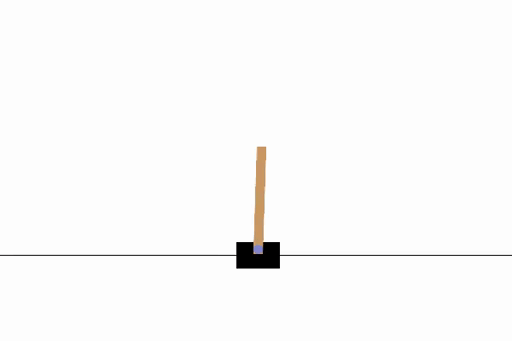
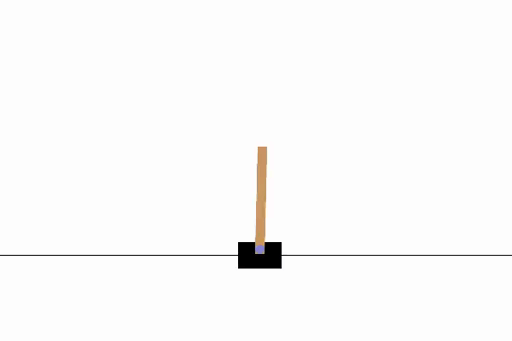

In [33]:
best_agent.demo_progression()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



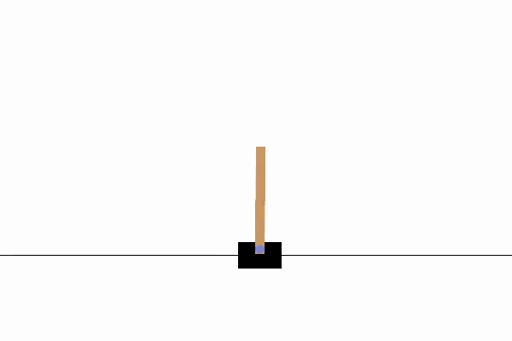
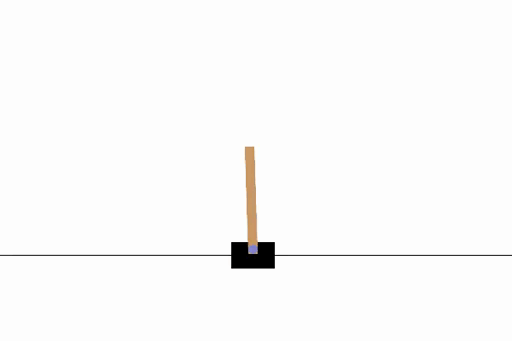

In [34]:
best_agent.demo_last()

In [35]:
gae_max_t, gae_max_r, gae_max_s, gae_max_sec, gae_max_rt = np.max(gae_results, axis=0).T
gae_min_t, gae_min_r, gae_min_s, gae_min_sec, gae_min_rt = np.min(gae_results, axis=0).T
gae_mean_t, gae_mean_r, gae_mean_s, gae_mean_sec, gae_mean_rt = np.mean(gae_results, axis=0).T
gae_x = np.arange(np.max(
    (len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [36]:
gae_root_dir = os.path.join(RESULTS_DIR, 'gae')
not os.path.exists(gae_root_dir) and os.makedirs(gae_root_dir)

np.save(os.path.join(gae_root_dir, 'x'), gae_x)

np.save(os.path.join(gae_root_dir, 'max_r'), gae_max_r)
np.save(os.path.join(gae_root_dir, 'min_r'), gae_min_r)
np.save(os.path.join(gae_root_dir, 'mean_r'), gae_mean_r)

np.save(os.path.join(gae_root_dir, 'max_s'), gae_max_s)
np.save(os.path.join(gae_root_dir, 'min_s'), gae_min_s )
np.save(os.path.join(gae_root_dir, 'mean_s'), gae_mean_s)

np.save(os.path.join(gae_root_dir, 'max_t'), gae_max_t)
np.save(os.path.join(gae_root_dir, 'min_t'), gae_min_t)
np.save(os.path.join(gae_root_dir, 'mean_t'), gae_mean_t)

np.save(os.path.join(gae_root_dir, 'max_sec'), gae_max_sec)
np.save(os.path.join(gae_root_dir, 'min_sec'), gae_min_sec)
np.save(os.path.join(gae_root_dir, 'mean_sec'), gae_mean_sec)

np.save(os.path.join(gae_root_dir, 'max_rt'), gae_max_rt)
np.save(os.path.join(gae_root_dir, 'min_rt'), gae_min_rt)
np.save(os.path.join(gae_root_dir, 'mean_rt'), gae_mean_rt)

## load from files

In [ ]:
!rm -f results/gae/*
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/x.npy

In [ ]:
gae_root_dir = os.path.join(RESULTS_DIR, 'gae')

gae_x = np.load(os.path.join(gae_root_dir, 'x.npy'))

gae_max_r = np.load(os.path.join(gae_root_dir, 'max_r.npy'))
gae_min_r = np.load(os.path.join(gae_root_dir, 'min_r.npy'))
gae_mean_r = np.load(os.path.join(gae_root_dir, 'mean_r.npy'))

gae_max_s = np.load(os.path.join(gae_root_dir, 'max_s.npy'))
gae_min_s = np.load(os.path.join(gae_root_dir, 'min_s.npy'))
gae_mean_s = np.load(os.path.join(gae_root_dir, 'mean_s.npy'))

gae_max_t = np.load(os.path.join(gae_root_dir, 'max_t.npy'))
gae_min_t = np.load(os.path.join(gae_root_dir, 'min_t.npy'))
gae_mean_t = np.load(os.path.join(gae_root_dir, 'mean_t.npy'))

gae_max_sec = np.load(os.path.join(gae_root_dir, 'max_sec.npy'))
gae_min_sec = np.load(os.path.join(gae_root_dir, 'min_sec.npy'))
gae_mean_sec = np.load(os.path.join(gae_root_dir, 'mean_sec.npy'))

gae_max_rt = np.load(os.path.join(gae_root_dir, 'max_rt.npy'))
gae_min_rt = np.load(os.path.join(gae_root_dir, 'min_rt.npy'))
gae_mean_rt = np.load(os.path.join(gae_root_dir, 'mean_rt.npy'))

## Plotting GAE

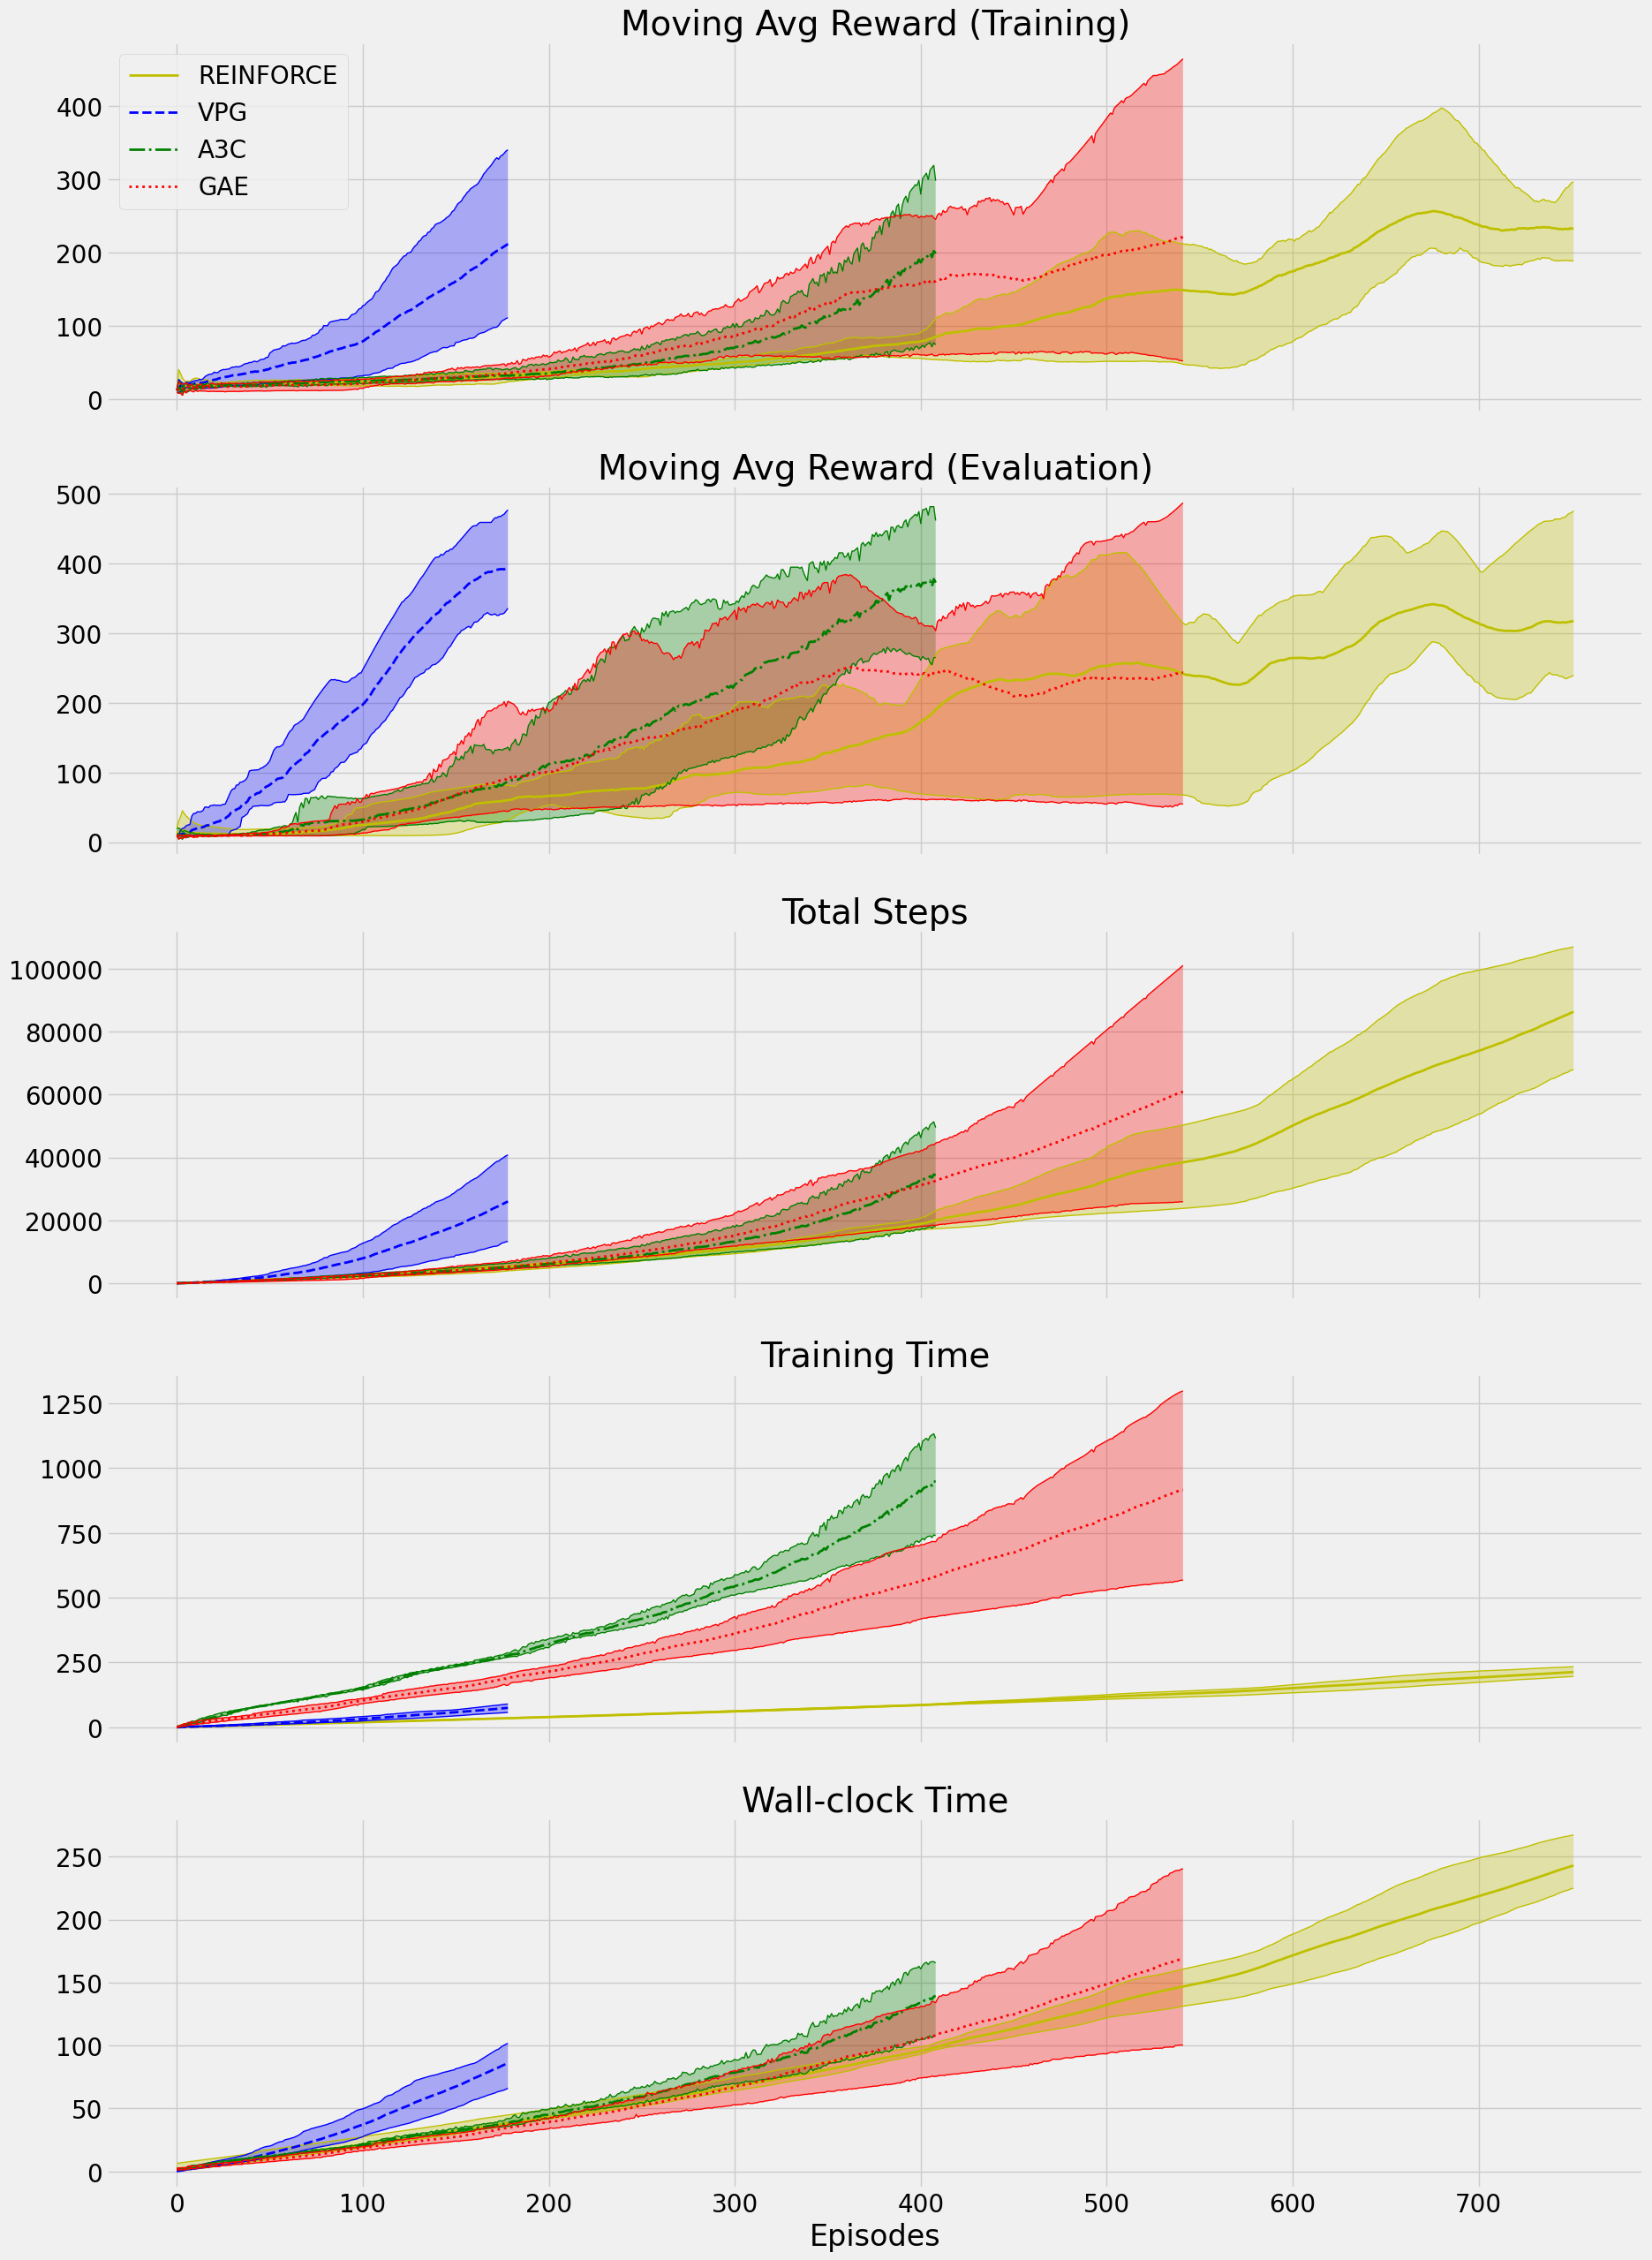

In [37]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(gae_max_rt, 'r', linewidth=1)
axs[4].plot(gae_min_rt, 'r', linewidth=1)
axs[4].plot(gae_mean_rt, 'r:', label='GAE', linewidth=2)
axs[4].fill_between(gae_x, gae_min_rt, gae_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# A2C
**Advantage Actor-Critic** (A2C) is synchronous version of A3C. In A2C we have multiple actors with a single learner.


## FCAC
Fully Connected Actor-Critic

In [50]:
# weight-sharing actor-critic neural network
class FCAC(nn.Module): # Fully Connected Actor-Critic
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super().__init__()
    self.activation_fc = activation_fc
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)
    self.value_output_layer = nn.Linear(hidden_dims[-1],1) # dim of value is 1
    self.policy_output_layer = nn.Linear(hidden_dims[-1], output_dim)

  def _format(self, state):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      if len(x.size()) == 1:
        x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    return self.policy_output_layer(x), self.value_output_layer(x)

  def full_pass(self, state):
    """convinience method to obtain probs, actions etc. needed for training
    * action - return an action that can be directly passed into the env
    * is_exploratory - flag indicating whether the action was exploratory
    * logpa - log prob of the action
    * entropy - entropy of the policy
    """
    logits, value = self.forward(state) # logits are preferences over actions
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    logpa = dist.log_prob(action).unsqueeze(-1) # log probability of the action
    entropy = dist.entropy().unsqueeze(-1)
    action = action.item() if len(action)==1 else action.data.numpy()
    is_exploratory = action != np.argmax(logits.detach().numpy(), axis=int(len(state)!=1))
    return action, is_exploratory, logpa, entropy, value

  def select_action(self, state):
    logits, _ = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    action = action.item() if len(action)==1 else action.data.numpy()
    return action

  # select the greedy action according to the policy
  def select_greedy_action(self, state):
    logits, _ = self.forward(state)
    return np.argmax(logits.detach().numpy())

  def evaluate_state(self, state):
    _, value = self.forward(state)
    return value


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Multi-process Environment
In A2C, we have a single agent driving the interaction with the environment. But, in this case the environent is a multi-process class that gathers samples from multiple environments at once.

The neural networks now need to porcess batches of data. Which means in A2C we can take advantage of GPUs, unlike A3C in which CPUs are the most important resource.

In [62]:
class MultiprocessEnv(object):
  def __init__(self, meke_env_fn, make_env_kargs, seed, n_workers):
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.n_workers = n_workers
    # pipes to communicate with workers; mp.Pipe() returns a tuple: (parent, child)
    # representing parent end of the connection and child end, respectively.
    self.pipes = [mp.Pipe() for rank in range(self.n_workers)]
    # create workers
    self.workers = [
        mp.Process(
            target=self.work,
            args=(rank, self.pipes[rank][1])
        ) for rank in range(self.n_workers)
    ]
    [w.start() for w in self.workers]
    self.dones = {rank:False for rank in range(self.n_workers)}

  def reset(self, rank=None, **kwargs):
    if rank is not None:
      parent_end, _ = self.pipes[rank]
      self.send_msg(('reset', {}), rank)
      o = parent_end.recv()
      return o
    self.broadcast_msg(('reset', kwargs))
    return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

  def step(self, actions):
    assert len(actions) == self.n_workers
    # broadcast the command and arguments to all workers
    [self.send_msg( ('step', {'action':actions[rank]}), rank) for rank in range(self.n_workers)]
    results = []
    for rank in range(self.n_workers):
      parent_end, _ = self.pipes[rank]
      o, r, d, i = parent_end.recv() # observations, rewards, dones, infos
      results.append( (o,
                       np.array(r, dtype=np.float32),
                       np.array(d, dtype=np.float32),
                       i))
    return [np.vstack(block) for block in np.array(results, dtype=np.object_).T]

  def close(self, **kwargs):
    self.broadcast_msg(('close', kwargs))
    [w.join() for w in self.workers]

  def _past_limit(self, **kwargs):
    self.broadcast_msg(('_past_limit', kwargs))
    return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

  def work(self, rank, worker_end):
    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed+rank)
    while True:
      cmd, kwargs = worker_end.recv() # listen for commands
      # each command calls the respective env function and sends the response
      # back to parent process.
      if cmd == 'reset':
        worker_end.send(env.reset(**kwargs))
      elif cmd == 'step':
        worker_end.send(env.step(**kwargs))
      elif cmd == '_past_limit':
        worker_end.send(env._elapsed_steps >= env._max_episode_steps)
      else:
        env.close(**kwargs) ; del env ; worker_end.close()
        break

  def send_msg(self, msg, rank):
    parent_end, _ = self.pipes[rank]
    parent_end.send(msg)

  def broadcast_msg(self, msg):
    [parent_end.send(msg) for parent_end, _ in self.pipes]

## A2C

In [84]:
class A2C():
  def __init__(self,
               ac_model_fn, # basically use FCAC
               ac_model_max_grad_norm, # for clipping gradients of NN params
               ac_optimizer_fn,
               ac_optimizer_lr,
               policy_loss_weight,
               value_loss_weight,
               entropy_loss_weight,
               max_n_steps,
               n_workers,
               tau):
    assert n_workers > 1
    self.ac_model_fn = ac_model_fn
    self.ac_model_max_grad_norm = ac_model_max_grad_norm
    self.ac_optimizer_fn = ac_optimizer_fn
    self.ac_optimizer_lr = ac_optimizer_lr

    self.policy_loss_weight = policy_loss_weight
    self.value_loss_weight = value_loss_weight
    self.entropy_loss_weight = entropy_loss_weight

    self.max_n_steps = max_n_steps
    self.n_workers = n_workers
    self.tau = tau


  def optimize_model(self):
    logpas = torch.stack(self.logpas).squeeze()
    entropies = torch.stack(self.entropies).squeeze()
    values = torch.stack(self.values).squeeze()

    # similar to VPG, but using input params instead of self.*
    T = len(self.rewards)
    # calculate the discounts as in all Monte-Carlo methods.
    # logspace() with these para returns the series of per-timestep gammas, e.g.[1, 0.99, 09801,...]
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    # calculate sum of discounted returns for all timesteps, i.e.
    # it's the returns for every timestep in the episode, from initial state at
    # timestep 0, to one before the terminal T-1.
    rewards = np.array(self.rewards).squeeze()
    returns = np.array([[np.sum(discounts[:T-t] * rewards[t:, w]) for t in range(T)]
                          for w in range(self.n_workers)])
    np_values = values.data.numpy()
    tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)
    advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]
    gaes = np.array([[np.sum(tau_discounts[:T-1-t] * advs[t:, w]) for t in range(T-1)]
                          for w in range(self.n_workers)])
    discounted_gaes = discounts[:-1] * gaes

    values = values[:-1,...].view(-1).unsqueeze(1)
    logpas = logpas.view(-1).unsqueeze(1)
    entropies = entropies.view(-1).unsqueeze(1)
    # returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
    # print(f'dim={returns.shape} .T[:-1] dim={returns.T[:-1].shape} floatTensor dim={torch.FloatTensor(returns.T[:-1]).shape}')
    # a=torch.FloatTensor(returns.T[:-1]).reshape(-1)
    # print(f'view(-1) dim={a.shape}')
    returns = torch.FloatTensor(returns.T[:-1]).reshape(-1).unsqueeze(1)
    discounted_gaes = torch.FloatTensor(discounted_gaes.T).reshape(-1).unsqueeze(1)

    T -= 1
    T *= self.n_workers
    assert returns.size() == (T, 1)
    assert values.size() == (T, 1)
    assert logpas.size() == (T, 1)
    assert entropies.size() == (T, 1)

    # calc the value_error to use it to score the log-probs or the actions.
    value_error = returns.detach() - values # adv fn: G_t-V(S_t; phi)
    value_loss = value_error.pow(2).mul(0.5).mean()
    # we want to maximise the performance measure J, so put '-' in front
    policy_loss = -(discounted_gaes.detach() * logpas).mean()
    entropy_loss = -entropies.mean()
    loss = self.policy_loss_weight * policy_loss + \
                self.value_loss_weight * value_loss + \
                self.entropy_loss_weight * entropy_loss

    # back prop
    self.ac_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.ac_model.parameters(),
                                   self.ac_model_max_grad_norm)
    self.ac_optimizer.step()

  def interaction_step(self, states, envs):
    actions, is_exploratory, logpas, entropies, values = self.ac_model.full_pass(states)
    new_states, rewards, is_terminals, _ = envs.step(actions)

    self.logpas.append(logpas)
    self.entropies.append(entropies)
    self.rewards.append(rewards)
    self.values.append(values)

    self.running_reward += rewards
    self.running_timestep += 1
    self.running_exploration += is_exploratory[:,np.newaxis].astype(np.int32)

    return new_states, is_terminals

  def train(self, make_envs_fn, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_envs_fn = make_envs_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    envs = self.make_envs_fn(make_env_fn, make_env_kargs, self.seed, self.n_workers)
    nS, nA = env.observation_space.shape[0], env.action_space.n
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    self.running_timestep = np.array([[0.],] * self.n_workers)
    self.running_reward = np.array([[0.],] * self.n_workers)
    self.running_exploration = np.array([[0.],] * self.n_workers)
    self.running_seconds = np.array([[time.time()],] * self.n_workers)
    self.episode_timestep, self.episode_reward = [], []
    self.episode_seconds, self.evaluation_scores = [], []
    self.episode_exploration = []

    self.ac_model = self.ac_model_fn(nS, nA)
    self.ac_optimizer = self.ac_optimizer_fn(self.ac_model,
                                             self.ac_optimizer_lr)
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    states = envs.reset()

    # collect n_steps rollout
    episode, n_steps_start = 0, 0
    self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
    for step in count(start=1):
      states, is_terminals = self.interaction_step(states, envs)

      if is_terminals.sum() or step - n_steps_start == self.max_n_steps:
        past_limits_enforced = envs._past_limit()
        is_failure = np.logical_and(is_terminals, np.logical_not(past_limits_enforced))
        next_values = self.ac_model.evaluate_state(
            states).detach().numpy() * (1 - is_failure)
        self.rewards.append(next_values) ; self.values.append(torch.Tensor(next_values))
        self.optimize_model()
        self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
        n_steps_start = step

      # stats
      if is_terminals.sum():
          episode_done = time.time()
          evaluation_score, _ = self.evaluate(self.ac_model, env)
          self.save_checkpoint(episode, self.ac_model)

          for i in range(self.n_workers):
            if is_terminals[i]:
              states[i] = envs.reset(rank=i)
              self.episode_timestep.append(self.running_timestep[i][0])
              self.episode_reward.append(self.running_reward[i][0])
              self.episode_exploration.append(self.running_exploration[i][0]/self.running_timestep[i][0])
              self.episode_seconds.append(episode_done - self.running_seconds[i][0])
              training_time += self.episode_seconds[-1]
              self.evaluation_scores.append(evaluation_score)
              episode += 1

              mean_10_reward = np.mean(self.episode_reward[-10:])
              std_10_reward = np.std(self.episode_reward[-10:])
              mean_100_reward = np.mean(self.episode_reward[-100:])
              std_100_reward = np.std(self.episode_reward[-100:])
              mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
              std_100_eval_score = np.std(self.evaluation_scores[-100:])
              mean_100_exp_rat = np.mean(self.episode_exploration[-100:])
              std_100_exp_rat = np.std(self.episode_exploration[-100:])

              total_step = int(np.sum(self.episode_timestep))
              wallclock_elapsed = time.time() - training_start
              result[episode-1] = total_step, mean_100_reward, \
                  mean_100_eval_score, training_time, wallclock_elapsed

          # debug stuff
          reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
          reached_max_minutes = wallclock_elapsed >= max_minutes * 60
          reached_max_episodes = episode + self.n_workers >= max_episodes
          reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
          training_is_over = reached_max_minutes or \
                              reached_max_episodes or \
                              reached_goal_mean_reward

          elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
          debug_message = 'el {}, ep {:04}, ts {:06}, '
          debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
          debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
          debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
          debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
          debug_message = debug_message.format(
              elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
              mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
              mean_100_eval_score, std_100_eval_score)
          print(debug_message, end='\r', flush=True)
          if reached_debug_time or training_is_over:
              print(ERASE_LINE + debug_message, flush=True)
              last_debug_time = time.time()
          if training_is_over:
              if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
              if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
              if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
              break

          # reset running variables for next time around
          self.running_timestep *= 1 - is_terminals
          self.running_reward *= 1 - is_terminals
          self.running_exploration *= 1 - is_terminals
          self.running_seconds[is_terminals.astype(np.bool_)] = time.time()

    final_eval_score, score_std = self.evaluate(self.ac_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
          ' {:.2f}s wall-clock time.\n'.format(
              final_eval_score, score_std, training_time, wallclock_time))
    env.close() ; del env
    envs.close() ; del envs
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time


  def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        if greedy:
          a = eval_policy_model.select_greedy_action(s)
        else:
          a = eval_policy_model.select_action(s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    #print(f'checkpoint_dir {self.checkpoint_dir}')
    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))

    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int32)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix

    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.ac_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.ac_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.ac_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.ac_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_gif_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    #print(f"save_checkpoint {episode_idx} !!!!!!!!!!!!!!!!")
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train A2C

In [85]:
a2c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
    'env_name': 'CartPole-v1',
    'gamma': 0.99,
    'max_minutes': 10,
    'max_episodes': 10000,
    'goal_mean_100_reward': 475
  }

  ac_model_fn = lambda nS, nA: FCAC(nS, nA, hidden_dims=(256,128))
  ac_model_max_grad_norm = 1
  # ac_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
  ac_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  ac_optimizer_lr = 0.001

  policy_loss_weight = 1.0
  value_loss_weight = 0.6

  entropy_loss_weight = 0.001

  max_n_steps = 10
  n_workers = 8
  tau = 0.95

  env_name, gamma, max_minutes, \
  max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = A2C(ac_model_fn,
              ac_model_max_grad_norm,
              ac_optimizer_fn,
              ac_optimizer_lr,
              policy_loss_weight,
              value_loss_weight,
              entropy_loss_weight,
              max_n_steps,
              n_workers,
              tau)

  make_envs_fn = lambda mef, mea, s, n: MultiprocessEnv(mef, mea, s, n)
  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallclock_time = agent.train(make_envs_fn,
                                                                        make_env_fn,
                                                                        make_env_kargs,
                                                                        seed,
                                                                        gamma,
                                                                        max_minutes,
                                                                        max_episodes,
                                                                        goal_mean_100_reward)
  a2c_results.append(result)
  if final_eval_score > best_eval_score:
      best_eval_score = final_eval_score
      best_agent = agent
a2c_results = np.array(a2c_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


el 00:00:00, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.7±0.0, ev 028.0±000.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


el 00:01:00, ep 0569, ts 060121, ar 10 346.2±055.9, 100 200.7±089.3, ex 100 0.2±0.0, ev 238.7±131.6
el 00:01:43, ep 0701, ts 106231, ar 10 500.0±000.0, 100 386.3±154.1, ex 100 0.2±0.0, ev 477.0±059.0
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 770.99s training time, 116.49s wall-clock time.

el 00:00:00, ep 0000, ts 000009, ar 10 009.0±000.0, 100 009.0±000.0, ex 100 0.9±0.0, ev 037.0±000.0
el 00:01:00, ep 0551, ts 059087, ar 10 286.7±139.1, 100 242.6±155.7, ex 100 0.3±0.0, ev 349.3±129.7
el 00:01:57, ep 0697, ts 115404, ar 10 500.0±000.0, 100 426.8±137.6, ex 100 0.2±0.0, ev 477.1±062.5
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 884.62s training time, 129.23s wall-clock time.

el 00:00:00, ep 0000, ts 000010, ar 10 010.0±000.0, 100 010.0±000.0, ex 100 0.2±0.0, ev 008.0±000.0
el 00:01:01, ep 0463, ts 039727, ar 10 220.9±096.5, 100 143.2±084.6, ex 100 0.3±0.0, ev 204.3±134.9
el 00:02:02, ep 0570, ts 0

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: http


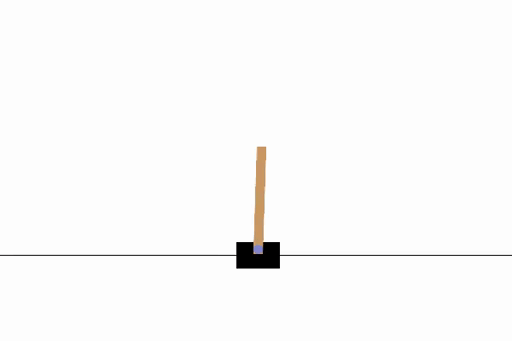
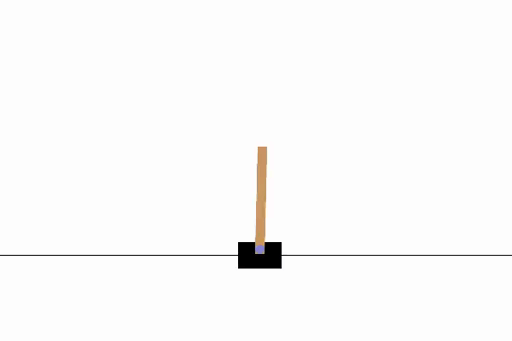

In [86]:
best_agent.demo_progression()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

error: render=True


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



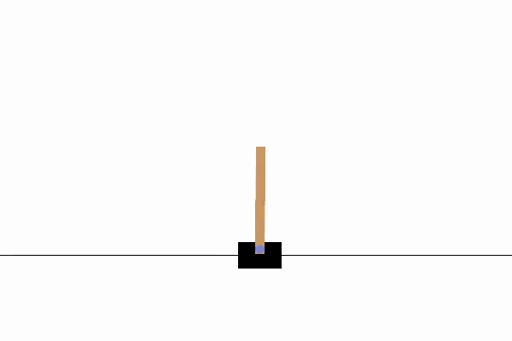
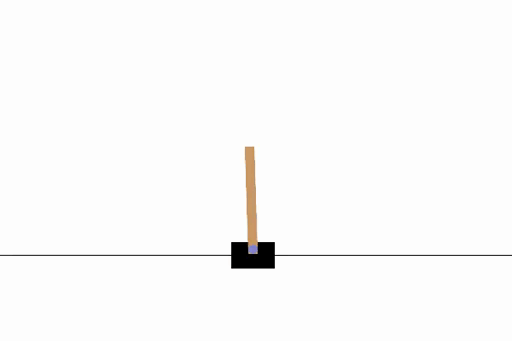

In [87]:
best_agent.demo_last()

In [89]:
a2c_max_t, a2c_max_r, a2c_max_s, a2c_max_sec, a2c_max_rt = np.max(a2c_results, axis=0).T
a2c_min_t, a2c_min_r, a2c_min_s, a2c_min_sec, a2c_min_rt = np.min(a2c_results, axis=0).T
a2c_mean_t, a2c_mean_r, a2c_mean_s, a2c_mean_sec, a2c_mean_rt = np.mean(a2c_results, axis=0).T
a2c_x = np.arange(np.max(
    (len(a2c_mean_s), len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [90]:
a2c_root_dir = os.path.join(RESULTS_DIR, 'a2c')
not os.path.exists(a2c_root_dir) and os.makedirs(a2c_root_dir)

np.save(os.path.join(a2c_root_dir, 'x'), a2c_x)

np.save(os.path.join(a2c_root_dir, 'max_r'), a2c_max_r)
np.save(os.path.join(a2c_root_dir, 'min_r'), a2c_min_r)
np.save(os.path.join(a2c_root_dir, 'mean_r'), a2c_mean_r)

np.save(os.path.join(a2c_root_dir, 'max_s'), a2c_max_s)
np.save(os.path.join(a2c_root_dir, 'min_s'), a2c_min_s )
np.save(os.path.join(a2c_root_dir, 'mean_s'), a2c_mean_s)

np.save(os.path.join(a2c_root_dir, 'max_t'), a2c_max_t)
np.save(os.path.join(a2c_root_dir, 'min_t'), a2c_min_t)
np.save(os.path.join(a2c_root_dir, 'mean_t'), a2c_mean_t)

np.save(os.path.join(a2c_root_dir, 'max_sec'), a2c_max_sec)
np.save(os.path.join(a2c_root_dir, 'min_sec'), a2c_min_sec)
np.save(os.path.join(a2c_root_dir, 'mean_sec'), a2c_mean_sec)

np.save(os.path.join(a2c_root_dir, 'max_rt'), a2c_max_rt)
np.save(os.path.join(a2c_root_dir, 'min_rt'), a2c_min_rt)
np.save(os.path.join(a2c_root_dir, 'mean_rt'), a2c_mean_rt)

## load from files

In [ ]:
!rm -f results/a2c/*
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/min_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/x.npy

In [ ]:
a2c_root_dir = os.path.join(RESULTS_DIR, 'a2c')

a2c_x = np.load(os.path.join(a2c_root_dir, 'x.npy'))

a2c_max_r = np.load(os.path.join(a2c_root_dir, 'max_r.npy'))
a2c_min_r = np.load(os.path.join(a2c_root_dir, 'min_r.npy'))
a2c_mean_r = np.load(os.path.join(a2c_root_dir, 'mean_r.npy'))

a2c_max_s = np.load(os.path.join(a2c_root_dir, 'max_s.npy'))
a2c_min_s = np.load(os.path.join(a2c_root_dir, 'min_s.npy'))
a2c_mean_s = np.load(os.path.join(a2c_root_dir, 'mean_s.npy'))

a2c_max_t = np.load(os.path.join(a2c_root_dir, 'max_t.npy'))
a2c_min_t = np.load(os.path.join(a2c_root_dir, 'min_t.npy'))
a2c_mean_t = np.load(os.path.join(a2c_root_dir, 'mean_t.npy'))

a2c_max_sec = np.load(os.path.join(a2c_root_dir, 'max_sec.npy'))
a2c_min_sec = np.load(os.path.join(a2c_root_dir, 'min_sec.npy'))
a2c_mean_sec = np.load(os.path.join(a2c_root_dir, 'mean_sec.npy'))

a2c_max_rt = np.load(os.path.join(a2c_root_dir, 'max_rt.npy'))
a2c_min_rt = np.load(os.path.join(a2c_root_dir, 'min_rt.npy'))
a2c_mean_rt = np.load(os.path.join(a2c_root_dir, 'mean_rt.npy'))

## Plotting A2C


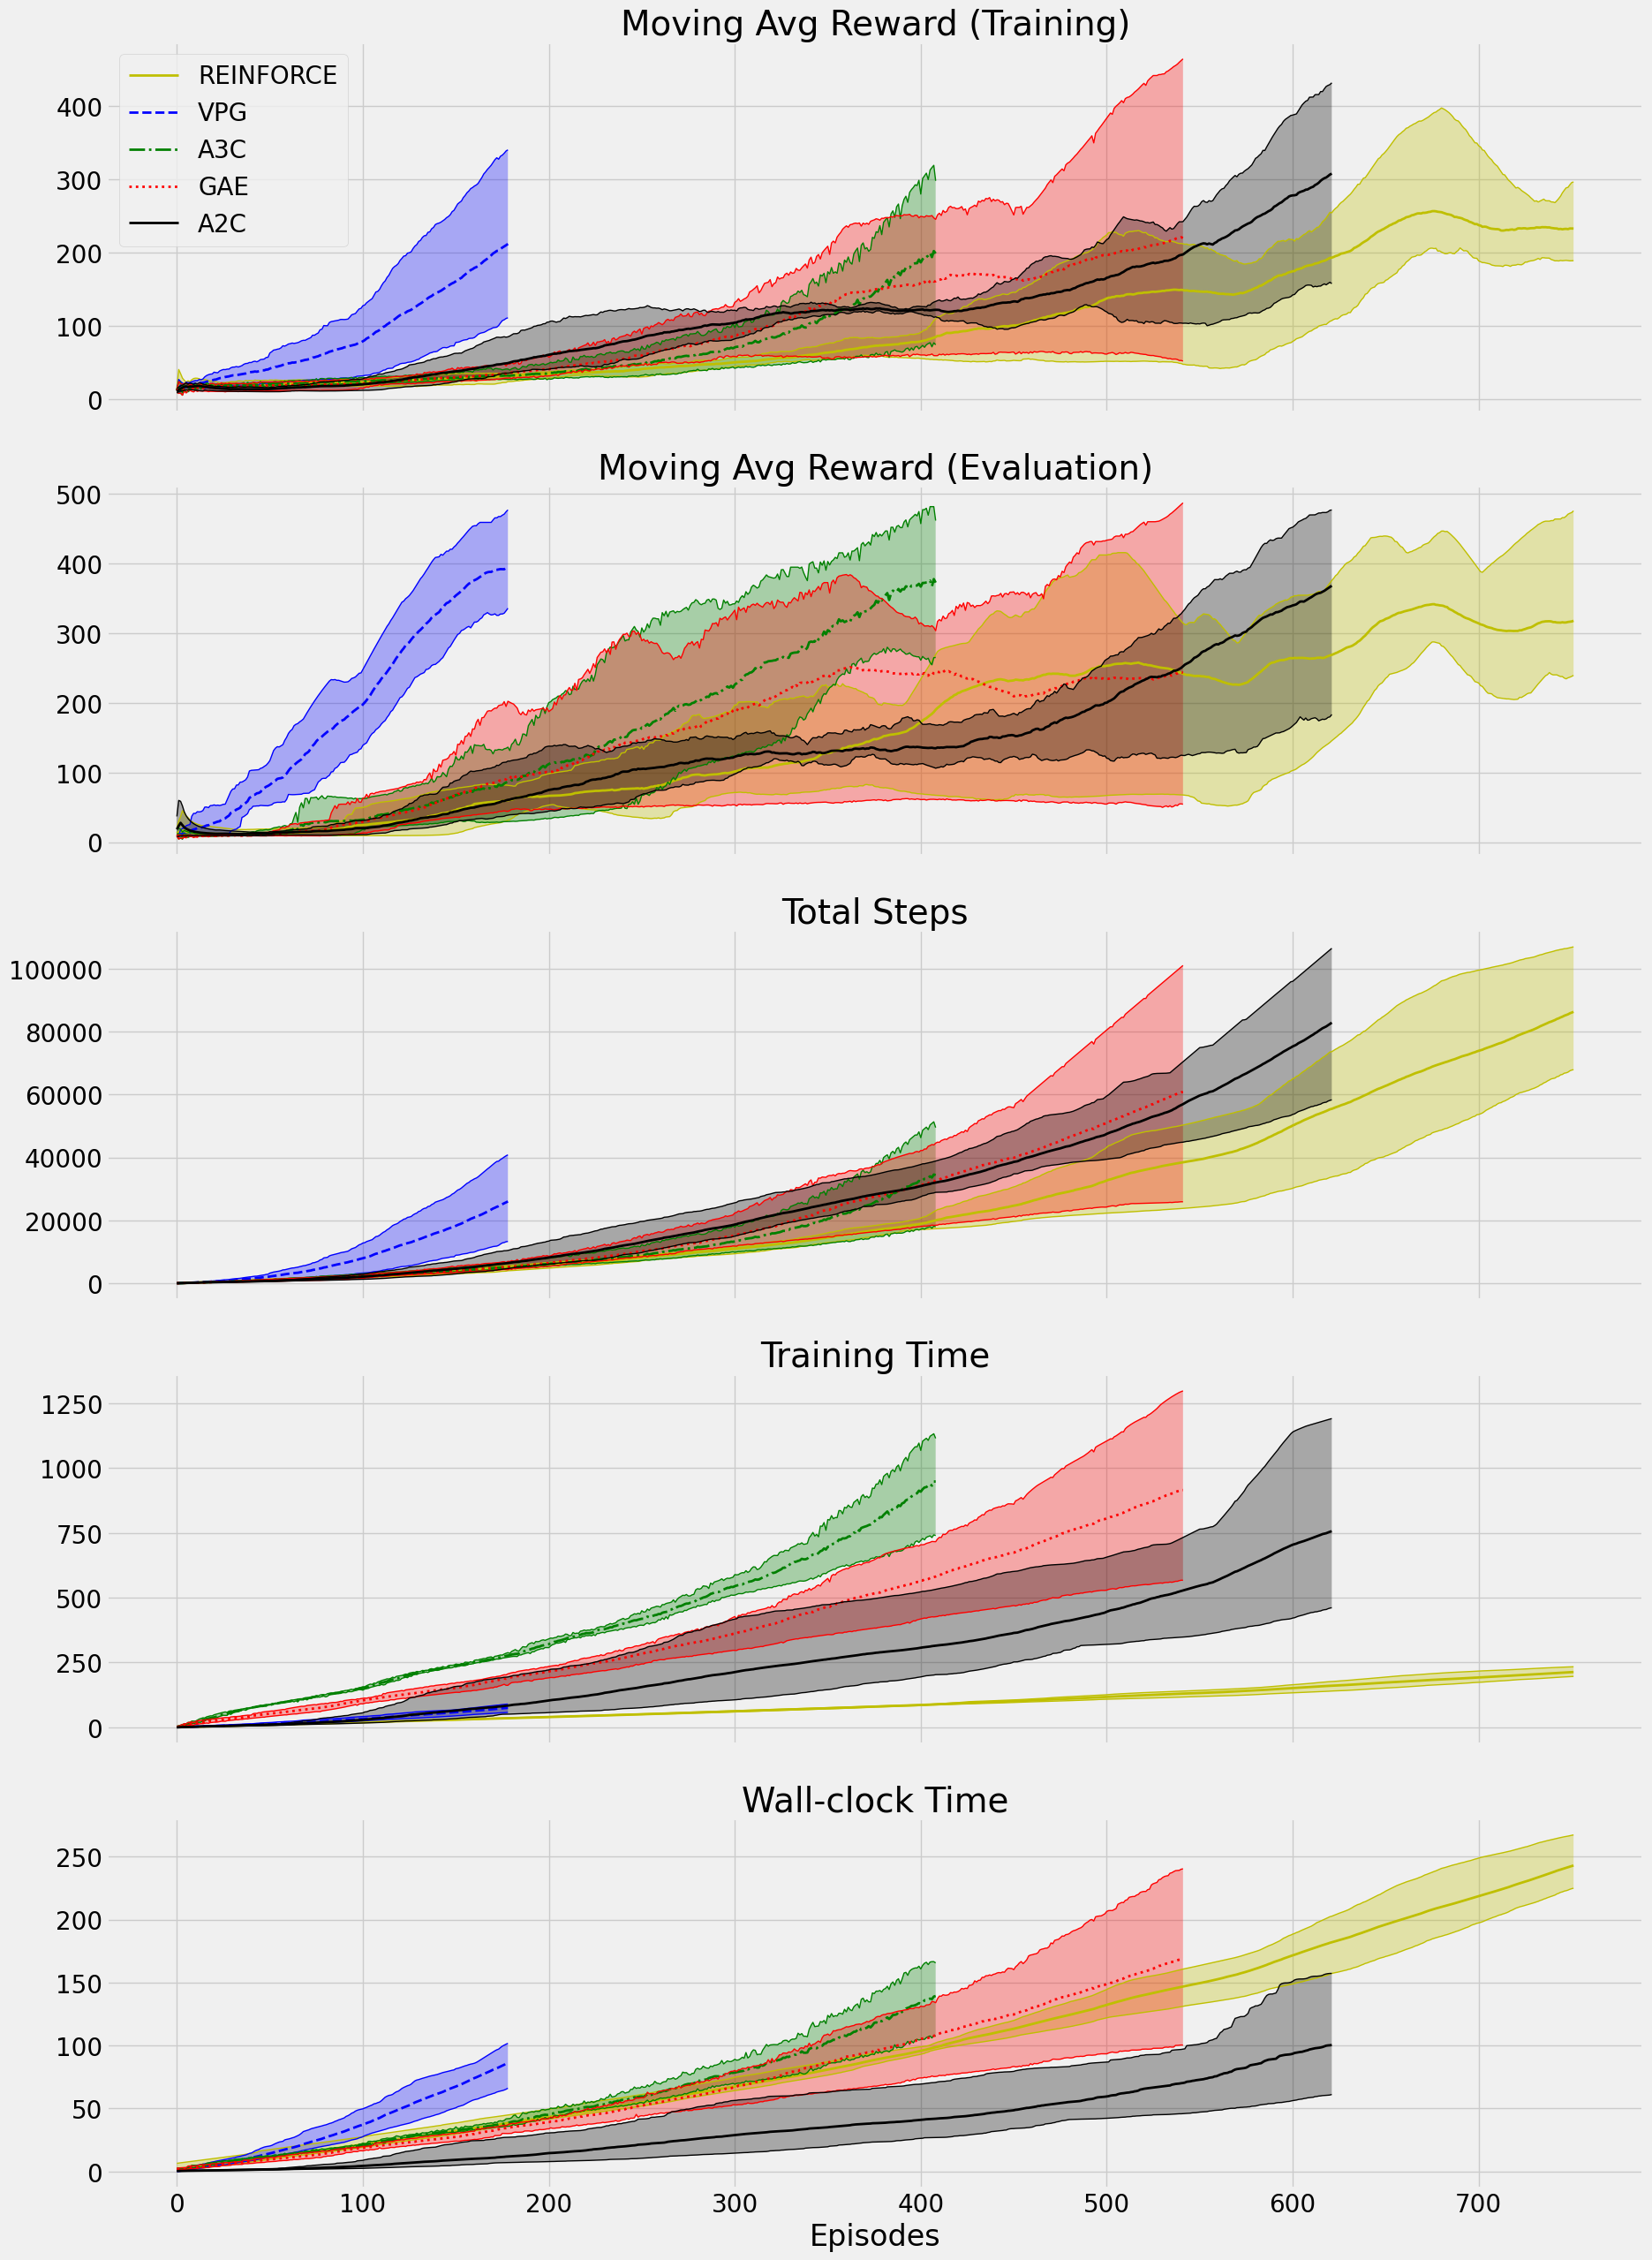

In [91]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(gae_max_rt, 'r', linewidth=1)
axs[4].plot(gae_min_rt, 'r', linewidth=1)
axs[4].plot(gae_mean_rt, 'r:', label='GAE', linewidth=2)
axs[4].fill_between(gae_x, gae_min_rt, gae_max_rt, facecolor='r', alpha=0.3)

# A2C
axs[0].plot(a2c_max_r, 'k', linewidth=1)
axs[0].plot(a2c_min_r, 'k', linewidth=1)
axs[0].plot(a2c_mean_r, 'k', label='A2C', linewidth=2)
axs[0].fill_between(a2c_x, a2c_min_r, a2c_max_r, facecolor='k', alpha=0.3)

axs[1].plot(a2c_max_s, 'k', linewidth=1)
axs[1].plot(a2c_min_s, 'k', linewidth=1)
axs[1].plot(a2c_mean_s, 'k', label='A2C', linewidth=2)
axs[1].fill_between(a2c_x, a2c_min_s, a2c_max_s, facecolor='k', alpha=0.3)

axs[2].plot(a2c_max_t, 'k', linewidth=1)
axs[2].plot(a2c_min_t, 'k', linewidth=1)
axs[2].plot(a2c_mean_t, 'k', label='A2C', linewidth=2)
axs[2].fill_between(a2c_x, a2c_min_t, a2c_max_t, facecolor='k', alpha=0.3)

axs[3].plot(a2c_max_sec, 'k', linewidth=1)
axs[3].plot(a2c_min_sec, 'k', linewidth=1)
axs[3].plot(a2c_mean_sec, 'k', label='A2C', linewidth=2)
axs[3].fill_between(a2c_x, a2c_min_sec, a2c_max_sec, facecolor='k', alpha=0.3)

axs[4].plot(a2c_max_rt, 'k', linewidth=1)
axs[4].plot(a2c_min_rt, 'k', linewidth=1)
axs[4].plot(a2c_mean_rt, 'k', label='A2C', linewidth=2)
axs[4].fill_between(a2c_x, a2c_min_rt, a2c_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

utils

In [92]:
s="""!rm -f results/gae/*
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/max_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/mean_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_r.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_rt.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_s.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_sec.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/min_t.npy
!wget -nv -P results/gae https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/gae/x.npy
"""
fr, to ='gae', 'a2c'
print(s.replace(fr, to))

!rm -f results/a2c/*
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_sec.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/max_t.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_r.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_rt.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/a2c/mean_s.npy
!wget -nv -P results/a2c https://raw.githubusercontent.com/romenlaw/RL-playground/ma

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
s="""gae_root_dir = os.path.join(RESULTS_DIR, 'gae')

gae_x = np.load(os.path.join(gae_root_dir, 'x.npy'))

gae_max_r = np.load(os.path.join(gae_root_dir, 'max_r.npy'))
gae_min_r = np.load(os.path.join(gae_root_dir, 'min_r.npy'))
gae_mean_r = np.load(os.path.join(gae_root_dir, 'mean_r.npy'))

gae_max_s = np.load(os.path.join(gae_root_dir, 'max_s.npy'))
gae_min_s = np.load(os.path.join(gae_root_dir, 'min_s.npy'))
gae_mean_s = np.load(os.path.join(gae_root_dir, 'mean_s.npy'))

gae_max_t = np.load(os.path.join(gae_root_dir, 'max_t.npy'))
gae_min_t = np.load(os.path.join(gae_root_dir, 'min_t.npy'))
gae_mean_t = np.load(os.path.join(gae_root_dir, 'mean_t.npy'))

gae_max_sec = np.load(os.path.join(gae_root_dir, 'max_sec.npy'))
gae_min_sec = np.load(os.path.join(gae_root_dir, 'min_sec.npy'))
gae_mean_sec = np.load(os.path.join(gae_root_dir, 'mean_sec.npy'))

gae_max_rt = np.load(os.path.join(gae_root_dir, 'max_rt.npy'))
gae_min_rt = np.load(os.path.join(gae_root_dir, 'min_rt.npy'))
gae_mean_rt = np.load(os.path.join(gae_root_dir, 'mean_rt.npy'))
"""
fr, to ='gae', 'a2c'
print(s.replace(fr, to))